# Assessment of climate change at near-term (2020-2040) over Northern Europe through internal variability storylines

Analysis codes developped by Aurélien Liné and Christophe Cassou.
CECI-Cerfacs, Toulouse, France

# Librairies importation
## Shared libraries importation

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from importlib import reload
import itertools
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import PercentFormatter
import numpy as np
import os
import pandas as pd
import scipy.stats
import sklearn.linear_model
import time
import xarray as xr

/var/folders/zm/8cqpwmmx1q1fjzl60kg8dq6h0000gn/T/ipykernel_54631/3069815809.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Personnal libraries importation

In [2]:
import sys
#sys.path.append('../LocalPackages/')

In [3]:
import cc
import cc.cmip6 as ccmip
import cc.storylines as ccivs
import cc.plot.maps as ccmps
import cc.plot.stats as ccplt
import cc.shli.matplotlib as ccmp
import cc.shli.numpy as ccnp
import cc.shli.scipy as ccscp
import cc.stats.extremes as ccxtr
import cc.stats.stats as ccsts
import cc.tools.time as cctim
import cc.tools.field as ccfld

# Paths to data and figures

In [4]:
inDir = '/data/home/globc/line/scratch/Data/Computed/'
inDir = './InputData/'
outDir = '/data/scratch/globc/line/Storylines/'
outDir = './ProducedData/'

# Analysis parameters

In [5]:
model = ['CNRM-CM6-1']
experiment = ['hist-ssp126', 'hist-ssp245', 'hist-ssp370', 'hist-ssp585']
drivers = ['amoc30N', 'nao']
temporality = 'JFM'
targets = [
    'tas_NEU_land',
    'pr_NEU_land',
    'prsn_NEU_land',
    'snc_NEU_land',
    'sfcWind_NEU_land',
    'rsds_NEU_land',
]
date_start = '1900'; date_stop = '2039'
refStr = '1995'; refEnd = '2014'; intStr = '2020'; intEnd = '2039'
anomaly = 'internal variability'
relative = True
zone = [ -12,   41.4,  29,  72.5]
lag = 0
confidence_range = .9
bp_median_mean = 'mean'; bp_box = .5; bp_ext = 1. - confidence_range
significance_limit = .05
confidence = 0.8 # 0.9
weighting_method = None
normalisation_method = None
return_period = [10]
extrema = ['min']
show_box = ['NEU']
period_names = ('present-day', 'near-term')
anomaly_name = 'change'
target_year = '2010'
bootstrap = False
n_boot = 1000

In [6]:
import matplotlib
matplotlib.rcParams.update({
    'text.usetex': False, # True
    'font.family': 'sans-serif', #"Helvetica",
    #'font.fontname': 'Helvetica',
})
mm = 1./25.4
# Nature figure parameters
## Figure sizes
single_column_width = 89*mm
double_column_width = 183*mm
extended_width = 120*mm
## Font sizes
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 7})
#matplotlib.rc('font', size=5)          # controls default text sizes
#matplotlib.rc('axes', titlesize=5)     # fontsize of the axes title
#matplotlib.rc('axes', labelsize=6)    # fontsize of the x and y labels
#matplotlib.rc('xtick', labelsize=5)    # fontsize of the tick labels
#matplotlib.rc('ytick', labelsize=5)    # fontsize of the tick labels
#matplotlib.rc('legend', fontsize=5)    # legend fontsize
#matplotlib.rc('figure', titlesize=8)  # fontsize of the figure title

# Pre-analysis routines

In [7]:
period_length = int(refEnd) - int(refStr) + 1
if int(intEnd) - int(intStr) + 1 != period_length:
    raise 'The two periods do not have the same length!'
period_gap = int(intStr) - int(refEnd) - 1
print(period_length, period_gap)

20 5


In [8]:
import cc.cmip6 as ccmip6
ccmip6 = reload(ccmip6)

delta = r'$\Delta$'
allModels = ['ACCESS-ESM1-5', 'CNRM-CM6-1', 'CanESM5', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-LR']
allSSPs = ['hist-ssp126', 'hist-ssp245', 'hist-ssp370', 'hist-ssp585']

if not isinstance(extrema, list):
    extrema = [extrema]

saveName = 'storyline'
if anomaly == 'internal variability':
    saveName += 'IV'
elif anomaly == 'super internal variability':
    saveName += 'SIV'
elif anomaly == 'forcing':
    saveName += 'F'
elif anomaly == 'mixed':
    saveName += 'X'
saveName += '_'+'-'.join(drivers) #+'-'.join(variable)+'_'
if normalisation_method == 'std':
    saveName += '_std'
    delta = r'$\tilde{\Delta}$'
if experiment == ['piControl']:
    saveName += '_length'+str(period_length)+'yr-gap'+str(period_gap)+'yr'
else:
    #saveName += '_ref'+refStr+refEnd+'-int'+intStr+intEnd
    saveName += '_'+intStr+intEnd+'-ref'+refStr+refEnd
saveName += '_'+temporality#+'_'+region+mask_land_sea
if model is None or set(model).intersection(set(allModels)) == set(allModels):
    saveName += '_allModels'
    model = allModels
else:
    model.sort()
    saveName += '_'+'-'.join([ccmip6.scenario_mip_dict[m]['short_name'] for m in model])
if experiment is None or set(experiment).intersection(set(allSSPs)) == set(allSSPs):
    saveName += '_allSSP'
else:
    saveName += '_'+'-'.join(experiment).replace('hist-', '').replace('-ssp', '-')
#if scale:
#    saveName += '_scaled'
#if normalize:
#    saveName += '_normalised'
#elif residual:
#    saveName += '_residual'
#saveName += '_'+'-'.join(variable)
saveName

'storylineIV_amoc30N-nao_20202039-ref19952014_JFM_CNRM_allSSP'

In [9]:
saveDir = outDir+saveName+'/'
dataDir = saveDir+'Data/'
figDir = saveDir+'Figures/'
if not os.path.exists(saveDir):
    os.makedirs(saveDir)
if not os.path.exists(dataDir):
    os.makedirs(dataDir)
if not os.path.exists(figDir):
    os.makedirs(figDir)
figExt = '.pdf' # pdf eps
saveDir

'./ProducedData/storylineIV_amoc30N-nao_20202039-ref19952014_JFM_CNRM_allSSP/'

In [10]:
ensemble_name = ['Mega\nensemble']
if len(model) == 1:
    if model == ['CNRM-CM6-1']:
        ensemble_name = ['CNRM-GE']
    else:
        ensemble_name = model # ['Large-ensemble']
elif set(model).intersection(set(allModels)) == set(allModels) and set(experiment).intersection(set(allSSPs)) == set(allSSPs):
    ensemble_name = ['CMIP-ME']
ensemble_name

['CNRM-GE']

In [11]:
target_dict = dict()

def update_target_dict(target_dict, targets):
    for _target in targets:
        _variable, _region, _ = _target.split('_')
        if _variable not in target_dict:
            if _variable == 'tas':
                target_dict[_variable] = 'T'
            elif _variable == 'prlq':
                target_dict[_variable] = 'rain'
            elif _variable == 'prsn':
                target_dict[_variable] = 'snowfall'
            elif _variable == 'sfcWind':
                target_dict[_variable] = 'wind'
            elif _variable == 'siconc':
                target_dict[_variable] = 'sea ice'
            else:
                target_dict[_variable] = _variable
        if _target not in target_dict:
            target_dict[_target] = target_dict[_variable]+'_{'+_region+'}'
    return target_dict

target_dict = update_target_dict(target_dict, targets)
target_dict

{'tas': 'T',
 'tas_NEU_land': 'T_{NEU}',
 'pr': 'pr',
 'pr_NEU_land': 'pr_{NEU}',
 'prsn': 'snowfall',
 'prsn_NEU_land': 'snowfall_{NEU}',
 'snc': 'snc',
 'snc_NEU_land': 'snc_{NEU}',
 'sfcWind': 'wind',
 'sfcWind_NEU_land': 'wind_{NEU}',
 'rsds': 'rsds',
 'rsds_NEU_land': 'rsds_{NEU}'}

In [12]:
_ylabel = {
    'tas': '$\Delta{T}$',
    'snc': '$\Delta{snowcover}$',
    'prsn': '$\Delta{S}$',
    'prlq': '$\Delta{R}$',
    'pr': '$\Delta{P}$',
    'sfcWind': '$\Delta{wind}$',
    'rsds': '$\Delta{solar}$'
}
_ylabel

{'tas': '$\\Delta{T}$',
 'snc': '$\\Delta{snowcover}$',
 'prsn': '$\\Delta{S}$',
 'prlq': '$\\Delta{R}$',
 'pr': '$\\Delta{P}$',
 'sfcWind': '$\\Delta{wind}$',
 'rsds': '$\\Delta{solar}$'}

In [13]:
int_low = (1. - confidence_range) / 2.; int_high = 1. - int_low
int_low, int_high

(0.04999999999999999, 0.95)

In [14]:
def color_unsignificant_red(val, significance_limit):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for significant
    pvalues, black otherwise.
    """
    color = 'red' if val > significance_limit else 'black'
    return 'color: %s' % color

h0 = {'T-test': 'Averages are significantly different.',
      'F-test': 'Sample variances are significantly different.'}

from IPython.display import display, HTML

In [15]:
subfigure_label = ['a) ', 'b) ', 'c) ', 'd) ', 'e) ', 'f) ', 'g) ', 'h) ', 'i) ', 'j) ', 'k) ']

# Drivers

## Loading data

In [16]:
reload(cctim)

begin = time.time()
list_of_files = os.listdir(inDir)
list_of_files.sort()
loaded_files = list()
driver_data = xr.Dataset(); driver_ano = xr.Dataset()

_anomaly = 'forcing' if anomaly == 'mixed' else anomaly
_anomaly = 'internal variability' if anomaly == 'super internal variability' else anomaly

for i, _driver in enumerate(drivers):
    if experiment == ['piControl']:
        if _driver == 'amvDemeaned':
            _driver = 'amvLinear'

    _name = _driver.upper()
    _prefix = temporality+'_'
    _lag = lag

    if _driver == 'amoc30N':
        _name = 'AMOC' # 'AMOC$_{30N}$'
        _prefix = 'yr_'
    elif _driver == 'amvLinear':
        _name = 'AMV'
        _prefix = 'yr_'
    elif _driver == 'amvLinearProjected':
        _name = 'AMV$^P$'
        _prefix = 'yr_'
    elif _driver == 'amvTrshea':
        _name = 'AMV$_{TrShea}$'
        _prefix = 'yr_'
    elif _driver == 'amvTrsheaProjected':
        _name = 'AMV$_{TrShea}^P$'
        _prefix = 'yr_'
    elif _driver == 'amvDemeaned':
        _name = 'AMV$_d$'
        _prefix = 'yr_'
    elif _driver == 'amvDemeanedProjected':
        _name = 'AMV$_d^P$'
        _prefix = 'yr_'
        #_lag = 10
    elif _driver == 'naoProjected':
        _name = 'NAO$^P$'
    elif _driver == 'eapProjected':
        _name = 'EAP$^P$'
    elif _driver == 'blProjected':
        _name = 'BL$^P$'
    elif _driver == 'nino34':
        _name = 'ENSO' #'El Niño'
        _prefix = 'yr_'

    list_data = list(); list_ano = list()
    for _model in model:
        if experiment != ['piControl']:
            _experiment = experiment or cc.cmip6.scenario_mip_dict[_model]['experiment']
            _experiment = list(set(_experiment).intersection(set(cc.cmip6.scenario_mip_dict[_model]['experiment'])))
        else:
            _experiment = ['piControl']
        for _experiment_id in _experiment:
            if _experiment_id in ('piControl'):
                _n_max = None; _date_start = None; _date_stop = None; _refStr = None; file_year_start = ''
            else:
                _n_max = 1; _date_start = date_start; _date_stop = date_stop; _refStr = refStr; file_year_start = '1850'
            tmp = list(); tmp_seasons = list()
            print(_driver+'_'+_prefix, _model, _experiment_id, file_year_start)
            for file in list_of_files:
                if _driver+'_'+_prefix in file and _model in file and _experiment_id in file and file_year_start in file:
                    print(inDir+file)
                    tmp.append(xr.open_dataset(inDir+file).get(_driver).sel(time=slice(_date_start, _date_stop)))
                    tmp[-1] = tmp[-1].sortby(tmp[-1].time)
                    if 'member' not in tmp[-1].coords:
                        tmp[-1] = tmp[-1].assign_coords({'member':_model+'_'+_experiment_id+'_'+_file.split('_')[2]})
                    if np.isnan(tmp[-1]).any():
                        print(tmp[-1])
                    _file = '_'.join(file.split('_')[2:])
                    if _file not in loaded_files:
                        loaded_files.append(_file)
            tmp = tmp[0] if len(tmp) == 1 else xr.concat(tmp, dim='member')
            #tmp = cc.get_season(tmp.resample(time='M').mean(dim = 'time', keep_attrs = True), temporality)
            tmp.name = _name
            if _experiment_id == 'piControl':
                tmp = tmp.assign_coords({'time': xr.cftime_range('1850', periods = len(tmp.time), freq = 'Y')})
            else:
                tmp = tmp.assign_coords({'time': xr.cftime_range(_date_start, periods = len(tmp.time), freq = 'Y')})
            list_data.append(tmp)
            list_ano.append(cctim.get_anomalies(
                data=list_data[-1], n_max=_n_max, calcul=_anomaly, relative=relative,
                start_year=_refStr, period_length=period_length, period_gap=period_gap, ref_start_year=_refStr))

    tmp_data = list_data[0] if len(list_data) == 1 else xr.concat(list_data, dim='member')
    tmp_ano = list_ano[0] if len(list_ano) == 1 else xr.concat(list_ano, dim='member')
    if i != 0:
        if experiment != ['piControl']:
            _common_members = list(set(driver_data.member.values).intersection(set(tmp_data.member.values))); _common_members.sort()
            tmp_data = tmp_data.sel(member = _common_members)
            driver_data = driver_data.sel(member = _common_members)
        _common_members = list(set(driver_ano.member.values).intersection(set(tmp_ano.member.values))); _common_members.sort()
        tmp_ano = tmp_ano.sel(member = _common_members)
        driver_ano = driver_ano.sel(member = _common_members)

    # Data used in the storyline analysis
    driver_data = driver_data.assign({_name: tmp_data})
    if experiment != ['piControl']:
        driver_data = driver_data.sortby('member')
    driver_ano = driver_ano.assign({_name: tmp_ano}).sortby('member')

end = time.time()
print('Runtime of the cell is', '{0:.1f}'.format(end - begin), 's')
driver_ano

amoc30N_yr_ CNRM-CM6-1 hist-ssp126 1850
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp126_r10i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp126_r11i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp126_r12i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp126_r13i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp126_r14i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp126_r15i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp126_r16i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp126_r17i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp126_r18i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp126_r19i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp126_r1i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp126_r20i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp126_r21i1p1f2_index

./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp245_r16i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp245_r17i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp245_r18i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp245_r19i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp245_r1i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp245_r20i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp245_r21i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp245_r22i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp245_r23i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp245_r24i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp245_r25i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp245_r26i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp245_r27i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNR

/var/folders/zm/8cqpwmmx1q1fjzl60kg8dq6h0000gn/T/ipykernel_54631/584770585.py:85: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
  tmp = tmp.assign_coords({'time': xr.cftime_range(_date_start, periods = len(tmp.time), freq = 'Y')})
/var/folders/zm/8cqpwmmx1q1fjzl60kg8dq6h0000gn/T/ipykernel_54631/584770585.py:85: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
  tmp = tmp.assign_coords({'time': xr.cftime_range(_date_start, periods = len(tmp.time), freq = 'Y')})


amoc30N_yr_ CNRM-CM6-1 hist-ssp585 1850
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp585_r10i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp585_r11i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp585_r12i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp585_r13i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp585_r14i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp585_r15i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp585_r16i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp585_r17i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp585_r18i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp585_r19i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp585_r1i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp585_r20i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp585_r21i1p1f2_index

/var/folders/zm/8cqpwmmx1q1fjzl60kg8dq6h0000gn/T/ipykernel_54631/584770585.py:85: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
  tmp = tmp.assign_coords({'time': xr.cftime_range(_date_start, periods = len(tmp.time), freq = 'Y')})
/var/folders/zm/8cqpwmmx1q1fjzl60kg8dq6h0000gn/T/ipykernel_54631/584770585.py:85: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
  tmp = tmp.assign_coords({'time': xr.cftime_range(_date_start, periods = len(tmp.time), freq = 'Y')})


./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp370_r8i1p1f2_index_1850-2039.nc
./InputData/amoc30N_yr_CNRM-CM6-1_hist-ssp370_r9i1p1f2_index_1850-2039.nc
nao_JFM_ CNRM-CM6-1 hist-ssp126 1850
./InputData/nao_JFM_CNRM-CM6-1_hist-ssp126_r10i1p1f2_index_1850-2039.nc
./InputData/nao_JFM_CNRM-CM6-1_hist-ssp126_r11i1p1f2_index_1850-2039.nc
./InputData/nao_JFM_CNRM-CM6-1_hist-ssp126_r12i1p1f2_index_1850-2039.nc
./InputData/nao_JFM_CNRM-CM6-1_hist-ssp126_r13i1p1f2_index_1850-2039.nc
./InputData/nao_JFM_CNRM-CM6-1_hist-ssp126_r14i1p1f2_index_1850-2039.nc
./InputData/nao_JFM_CNRM-CM6-1_hist-ssp126_r15i1p1f2_index_1850-2039.nc
./InputData/nao_JFM_CNRM-CM6-1_hist-ssp126_r16i1p1f2_index_1850-2039.nc
./InputData/nao_JFM_CNRM-CM6-1_hist-ssp126_r17i1p1f2_index_1850-2039.nc
./InputData/nao_JFM_CNRM-CM6-1_hist-ssp126_r18i1p1f2_index_1850-2039.nc
./InputData/nao_JFM_CNRM-CM6-1_hist-ssp126_r19i1p1f2_index_1850-2039.nc
./InputData/nao_JFM_CNRM-CM6-1_hist-ssp126_r1i1p1f2_index_1850-2039.nc
./InputData/nao_JFM_CNRM

/var/folders/zm/8cqpwmmx1q1fjzl60kg8dq6h0000gn/T/ipykernel_54631/584770585.py:85: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
  tmp = tmp.assign_coords({'time': xr.cftime_range(_date_start, periods = len(tmp.time), freq = 'Y')})
/var/folders/zm/8cqpwmmx1q1fjzl60kg8dq6h0000gn/T/ipykernel_54631/584770585.py:85: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
  tmp = tmp.assign_coords({'time': xr.cftime_range(_date_start, periods = len(tmp.time), freq = 'Y')})


./InputData/nao_JFM_CNRM-CM6-1_hist-ssp585_r18i1p1f2_index_1850-2039.nc
./InputData/nao_JFM_CNRM-CM6-1_hist-ssp585_r19i1p1f2_index_1850-2039.nc
./InputData/nao_JFM_CNRM-CM6-1_hist-ssp585_r1i1p1f2_index_1850-2039.nc
./InputData/nao_JFM_CNRM-CM6-1_hist-ssp585_r20i1p1f2_index_1850-2039.nc
./InputData/nao_JFM_CNRM-CM6-1_hist-ssp585_r21i1p1f2_index_1850-2039.nc
./InputData/nao_JFM_CNRM-CM6-1_hist-ssp585_r22i1p1f2_index_1850-2039.nc
./InputData/nao_JFM_CNRM-CM6-1_hist-ssp585_r23i1p1f2_index_1850-2039.nc
./InputData/nao_JFM_CNRM-CM6-1_hist-ssp585_r24i1p1f2_index_1850-2039.nc
./InputData/nao_JFM_CNRM-CM6-1_hist-ssp585_r25i1p1f2_index_1850-2039.nc
./InputData/nao_JFM_CNRM-CM6-1_hist-ssp585_r26i1p1f2_index_1850-2039.nc
./InputData/nao_JFM_CNRM-CM6-1_hist-ssp585_r27i1p1f2_index_1850-2039.nc
./InputData/nao_JFM_CNRM-CM6-1_hist-ssp585_r28i1p1f2_index_1850-2039.nc
./InputData/nao_JFM_CNRM-CM6-1_hist-ssp585_r29i1p1f2_index_1850-2039.nc
./InputData/nao_JFM_CNRM-CM6-1_hist-ssp585_r2i1p1f2_index_1850-20

/var/folders/zm/8cqpwmmx1q1fjzl60kg8dq6h0000gn/T/ipykernel_54631/584770585.py:85: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
  tmp = tmp.assign_coords({'time': xr.cftime_range(_date_start, periods = len(tmp.time), freq = 'Y')})
/var/folders/zm/8cqpwmmx1q1fjzl60kg8dq6h0000gn/T/ipykernel_54631/584770585.py:85: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
  tmp = tmp.assign_coords({'time': xr.cftime_range(_date_start, periods = len(tmp.time), freq = 'Y')})


<xarray.Dataset> Size: 17kB
Dimensions:  (member: 120)
Coordinates:
    j-mean   float32 4B 196.0
    sector   |S255 255B b'atlantic_arctic_ocean'
  * member   (member) <U32 15kB 'CNRM-CM6-1_hist-ssp126_r10i1p1f2' ... 'CNRM-...
Data variables:
    AMOC     (member) float32 480B -2.617 -1.843 -2.866 ... 0.8565 -1.584 -1.461
    NAO      (member) float32 480B 0.8252 -0.4051 0.3413 ... 0.1208 0.06652

In [17]:
members = list(driver_ano.member.values) #.sort()
members.sort()
members_dict = cc.cmip6.get_members_dict(members)
members_dict

{'CNRM-CM6-1': {'hist-ssp126': ['CNRM-CM6-1_hist-ssp126_r10i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r11i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r12i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r13i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r14i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r15i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r16i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r17i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r18i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r19i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r1i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r20i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r21i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r22i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r23i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r24i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r25i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r26i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r27i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r28i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r29i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r2i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r30i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r3i1p1f2',
   'CNRM-CM6-1_hist-ssp126_r4i1p1f2',


In [18]:
source_dict = {}
if len(members_dict) == 1:
    source_dict[model[0]] = model[0]
else:
    for _model in members_dict:
        if len(members_dict[_model]) == 1:
            source_dict[_model] = cc.cmip6.scenario_mip_dict[_model]['short_name'] +'-LE'
        else:
            source_dict[_model] = cc.cmip6.scenario_mip_dict[_model]['short_name'] +'-GE'
source_dict

{'CNRM-CM6-1': 'CNRM-CM6-1'}

## Computing members' weights

In [19]:
if weighting_method == 'model_scenario':
    weight = list()
    for _member in driver_ano.member.values:
        _model, _scenario, _ = _member.split('_')
        _N = len(members_dict[_model][_scenario])
        #print(_model, _scenario, _N)
        weight.append(1/_N)
elif weighting_method == 'model':
    weight = list()
    for _member in driver_ano.member.values:
        _model, _, _ = _member.split('_')
        _N = 0
        for _scenario in members_dict[_model].keys():
            _N += len(members_dict[_model][_scenario])
        #print(_model, _scenario, _N)
        weight.append(1/_N)
elif weighting_method == 'scenario':
    weight = list()
    for _member in driver_ano.member.values:
        _, _scenario, _ = _member.split('_')
        _N = 0
        for _model in members_dict.keys():
            _N += len(members_dict[_model][_scenario])
        #print(_model, _scenario, _N)
        weight.append(1/_N)
else:
    weight = None

if weight is None:
    da_weight = xr.ones_like(driver_ano.member, dtype='float').sortby('member')
else:
    da_weight = xr.DataArray(weight, dims = ['member'], coords = {'member': driver_ano.member.values}).sortby('member')
da_weight

<xarray.DataArray 'member' (member: 120)> Size: 960B
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])
Coordinates:
    j-mean   float32 4B 196.0
    sector   |S255 255B b'atlantic_arctic_ocean'
  * member   (member) <U32 15kB 'CNRM-CM6-1_hist-ssp126_r10i1p1f2' ... 'CNRM-...

{'CNRM-CM6-1': 'o'} {'CNRM-CM6-1': '**'}


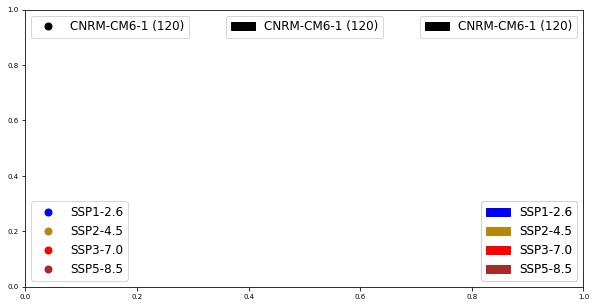

In [20]:
ccmip6 = reload(ccmip6)

ms_size = 7 # 10

if len(model) == 1:
    box_fill = True
    list_of_markers = ['o']
    list_of_hatches = [None]
else:
    box_fill = False
    list_of_markers = ['o', '^', 's', '*', 'p', 'D', 'X']
    list_of_hatches = ['o', '*', 'O', '.', '-', '/', '\\', '///', '\\\\'] # None

model_markers = dict(); model_legend_point = list()
model_hatches = dict(); model_legend_box = list()
model_colors = dict(); model_legend_color = list()
experiments = list()

for iM, m in enumerate(model):
    _total = str(len([_member for _member in members if m in _member]))
    if len(model) == 1:
        model_markers[m] = 'o'
        model_legend_point.append(mlines.Line2D([], [], color = 'k', marker = 'o', ms = ms_size, linestyle = '', label = source_dict[m]+' ('+_total+')'))
        model_colors[m] = 'k'
        model_legend_color.append(mpatches.Patch(color = 'k', fill = True, label = source_dict[m]+' ('+_total+')'))
    else:
        model_markers[m] = ccmip6.scenario_mip_dict[m]['marker']
        model_legend_point.append(mlines.Line2D([], [], color = 'k', marker = model_markers[m], ms = ms_size, linestyle = '', label = source_dict[m]+' ('+_total+')'))
        model_colors[m] = ccmip6.scenario_mip_dict[m]['color']
        model_legend_color.append(mpatches.Patch(color = model_colors[m], fill = True, label = source_dict[m]+' ('+_total+')'))
    model_hatches[m] = ccmip6.scenario_mip_dict[m]['hatch']
    model_legend_box.append(mpatches.Patch(color = 'k', fill = box_fill, hatch = model_hatches[m], label = source_dict[m]+' ('+_total+')'))
    #model_colors[m] = ccmip6.scenario_mip_dict[m]['color']
    #model_legend_color.append(mpatches.Patch(color = model_colors[m], fill = True, label = source_dict[m]+' ('+_total+')'))
    for _experiment in members_dict[m].keys():
        if _experiment not in experiments:
            experiments.append(_experiment)
    experiments.sort()

experiment_colors = dict()
experiment_labels = dict()
experiment_legend_point = list(); experiment_legend_box = list()
for _experiment in experiments:
    experiment_colors[_experiment] = cc.cmip6.experiment_dict[_experiment]['color']
    experiment_labels[_experiment] = cc.cmip6.experiment_dict[_experiment]['name']
    experiment_legend_point.append(mlines.Line2D([], [], color = experiment_colors[_experiment],
                                                 marker = 'o', ms = ms_size, linestyle = '',
                                                 label = experiment_labels[_experiment]))
    experiment_legend_box.append(mpatches.Patch(color = experiment_colors[_experiment], fill = True,
                                                label = experiment_labels[_experiment]))

fig, ax = plt.subplots(figsize = (10, 5))
lgd = plt.legend(handles = model_legend_color, loc='upper center', fontsize=12); ax.add_artist(lgd)
lgd = plt.legend(handles = model_legend_point, loc='upper left', fontsize=12); ax.add_artist(lgd)
lgd = plt.legend(handles = model_legend_box, loc='upper right', fontsize=12); ax.add_artist(lgd)
lgd = plt.legend(handles = experiment_legend_point, loc='lower left', fontsize=12); ax.add_artist(lgd)
lgd = plt.legend(handles = experiment_legend_box, loc='lower right', fontsize=12); ax.add_artist(lgd)

print(model_markers, model_hatches)

## Drivers' preliminary analysis

In [21]:
print('Driver    '+str(refStr)+'-'+str(refEnd)+' '+str(intStr)+'-'+str(intEnd)+' Change    (%)')

for _driver in driver_ano:
    _int_data = float(driver_data[_driver].sel(time=slice(intStr, intEnd)).mean())
    _ref_data = float(driver_data[_driver].sel(time=slice(refStr, refEnd)).mean())
    print(' '.join([
        '{:<9}'.format(_driver),
        '{:0<9f}'.format(_ref_data),
        '{:0<9f}'.format(_int_data),
        '{:0<9f}'.format(_int_data - _ref_data),
        '({:0<9f}%)'.format((_int_data - _ref_data) / _ref_data * 100.),
    ]))

Driver    1995-2014 2020-2039 Change    (%)
AMOC      16.570219 14.531717 -2.038502 (-12.302202%)
NAO       0.0542690 0.1337520 0.0794830 (146.462337%)


In [22]:
for _driver in driver_ano:
    print(_driver)
    print('Average change:', '{0:.3f}'.format(driver_ano[_driver].weighted(da_weight).mean().values))
    _neg = np.sum(driver_ano[_driver].values <= 0.)
    _pos = np.sum(driver_ano[_driver].values >= 0.)
    _tot = len(driver_ano[_driver].values)
    print('Negative anomalies:', _neg, '({0:.1f}%)'.format(_neg/_tot*100.))
    print('Positive anomalies:', _pos, '({0:.1f}%)'.format(_pos/_tot*100.))
    print()
#print('A weighted method shoud be applied if multiple models used... (sum of weights)')

AMOC
Average change: -2.039
Negative anomalies: 107 (89.2%)
Positive anomalies: 13 (10.8%)

NAO
Average change: 0.079
Negative anomalies: 49 (40.8%)
Positive anomalies: 71 (59.2%)



In [23]:
ccscp = reload(ccscp)

_variable = 'toto'

ds_corr_test = xr.Dataset()
_corr_store1 = list()
for _driver1 in driver_ano:
    _corr_store2 = list()
    for _driver2 in driver_ano:
        _corr = ccscp.pearson(driver_ano.get(_driver1), driver_ano.get(_driver2), weights = da_weight)
        _corr_store2.append(_corr)

    _corr_store1.append(_corr_store2)

ds_corr_test = ds_corr_test.assign(
    {_variable:xr.DataArray(np.array(_corr_store1).transpose(),
                            dims=['test', 'r', 'c'],
                            coords={
                                'test': ['Correlation', 'p-value'],
                                'r':driver_ano.data_vars,
                                'c':driver_ano.data_vars})})
for _variable in ds_corr_test:
    print('Null hypothesis: "The correlation is not significative."')
    display(ds_corr_test.get(_variable).sel(test='Correlation').to_pandas())
    print('p-values')
    display(ds_corr_test.get(_variable).sel(test='p-value').to_pandas().style.format("{:.2%}").applymap(lambda x: color_unsignificant_red(x, significance_limit=significance_limit)))

if len(model) != 1:
    for _model in model:
        print(_model)
        ds_corr_test = xr.Dataset()
        _corr_store1 = list()
        for _driver1 in driver_ano:
            _corr_store2 = list()
            for _driver2 in driver_ano:
                a = list()
                b = list()
                w = list()
                for _experiment in members_dict[_model].keys():
                    a = a + list(driver_ano.get(_driver1).sel(member = members_dict[_model][_experiment]).values)
                    b = b + list(driver_ano.get(_driver2).sel(member = members_dict[_model][_experiment]).values)
                    w = w + list(da_weight.sel(member = members_dict[_model][_experiment]).values)
                _corr = ccscp.pearson(a, b, weights = w)
                _corr_store2.append(_corr)

            _corr_store1.append(_corr_store2)

        ds_corr_test = ds_corr_test.assign(
            {_variable:xr.DataArray(np.array(_corr_store1).transpose(),
                                    dims=['test', 'r', 'c'],
                                    coords={'test': ['Correlation', 'p-value'], 'r':driver_ano.data_vars, 'c':driver_ano.data_vars})})
        for _variable in ds_corr_test:
            print('Null hypothesis: "The correlation is not significative."')
            display(ds_corr_test.get(_variable).sel(test='Correlation').to_pandas())
            print('p-values')
            display(ds_corr_test.get(_variable).sel(test='p-value').to_pandas().style.format("{:.2%}").applymap(lambda x: color_unsignificant_red(x, significance_limit=significance_limit)))


Null hypothesis: "The correlation is not significative."


c,AMOC,NAO
r,,
AMOC,1.000000,-0.410523
NAO,-0.410523,1.000000


p-values


/var/folders/zm/8cqpwmmx1q1fjzl60kg8dq6h0000gn/T/ipykernel_54631/3804958265.py:26: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(ds_corr_test.get(_variable).sel(test='p-value').to_pandas().style.format("{:.2%}").applymap(lambda x: color_unsignificant_red(x, significance_limit=significance_limit)))


c,AMOC,NAO
r,,
AMOC,0.00%,0.00%
NAO,0.00%,0.00%


In [24]:
driver_ano_std = xr.Dataset()
for _driver in driver_ano:
    driver_ano_std = driver_ano_std.assign({_driver: cc.cmip6.standardisation(driver_ano.get(_driver))})
driver_ano_std

<xarray.Dataset> Size: 17kB
Dimensions:  (member: 120)
Coordinates:
    j-mean   float32 4B 196.0
    sector   |S255 255B b'atlantic_arctic_ocean'
  * member   (member) <U32 15kB 'CNRM-CM6-1_hist-ssp126_r10i1p1f2' ... 'CNRM-...
Data variables:
    AMOC     (member) float32 480B -0.3673 0.1366 -0.5295 ... 0.2819 0.3617
    NAO      (member) float32 480B 1.952 -1.289 0.6772 ... 0.06486 -0.09779

# Construction of storylines based on internal variability drivers

In [25]:
ccivs = reload(ccivs)

if normalisation_method == 'std':
    main_driver_ano = driver_ano_std
    delta_print=r'$\tilde{\Delta}$'
else:
    main_driver_ano = driver_ano
    delta_print=r'$\Delta$'

begin = time.time()
story = ccivs.storylines(confidence=confidence, prints=False, delta=delta_print)
for _driver in main_driver_ano.data_vars:
    story.add_driver(main_driver_ano.get(_driver))
story.add_weights(da_weight)
story.build_storylines()
story_legend_color = list(); story_legend_point = list(); story_legend_cross = list()
for i, _sto in enumerate(story.labels):
    story_legend_color.append(mpatches.Patch(color = story.colors[i], label = _sto))
    story_legend_point.append(mlines.Line2D([], [], color = story.colors[i], marker = 'o', ms = 10, linestyle = '', label = _sto))
    story_legend_cross.append(mlines.Line2D([], [], color = story.colors[i], marker = 'X', ms = 12, linestyle = '', mec='w', label = story.stories[i]))
end = time.time()
print('Runtime of the storyline classification is', '{0:.1f}'.format(end - begin), 's')

story

[[1.51636374 0.32560182]
 [0.32560182 1.51636374]]
[-0.13522011 -0.82336967]
[[1.51636374 0.32560182]
 [0.32560182 1.51636374]]
[-0.35505799 -0.20379005]
[[1.51636374 0.32560182]
 [0.32560182 1.51636374]]
[-0.58857718 -0.35338168]
[[1.51636374 0.32560182]
 [0.32560182 1.51636374]]
[-0.79074733 -0.76869802]
[[1.51636374 0.32560182]
 [0.32560182 1.51636374]]
[-1.93156585  0.02109347]
[[1.51636374 0.32560182]
 [0.32560182 1.51636374]]
[ 1.27646796 -2.65635842]
[[1.51636374 0.32560182]
 [0.32560182 1.51636374]]
[-0.15283653 -1.09313014]
[[1.51636374 0.32560182]
 [0.32560182 1.51636374]]
[ 0.57782663 -0.42577169]
[[1.51636374 0.32560182]
 [0.32560182 1.51636374]]
[-0.51827488  0.25367101]
[[1.51636374 0.32560182]
 [0.32560182 1.51636374]]
[ 0.27009342 -1.21231308]
[[1.51636374 0.32560182]
 [0.32560182 1.51636374]]
[ 1.89335485 -0.4425138 ]
[[1.51636374 0.32560182]
 [0.32560182 1.51636374]]
[-0.37881231  1.03524316]
[[1.51636374 0.32560182]
 [0.32560182 1.51636374]]
[-1.0114821  -0.10897186]

In [26]:
story.outputs.storindex

<xarray.DataArray 'storindex' (story: 4, driver: 2)> Size: 64B
array([[-0.54917116,  0.43963768],
       [ 0.26531276, -0.47763294],
       [-4.34231297,  0.63659898],
       [-3.52782905, -0.28067164]])
Coordinates:
  * story    (story) <U2 32B 'AN' 'An' 'aN' 'an'
  * driver   (driver) <U4 32B 'AMOC' 'NAO'

In [27]:
print('{:<12}'.format(' ')+''.join(['{:>5}'.format(_sto) for _sto in story.stories]))
for _experiment in experiments:
    print('{:<12}'.format(_experiment)+''.join(['{:>5}'.format(len(
        [_member for _member in story.families[_sto]['label'] if _experiment in _member]
    )) for _sto in story.stories]))
print('{:<12}'.format('Total')+''.join(['{:>5}'.format(len(
    story.families[_sto]['label'])) for _sto in story.stories]))

               AN   An   aN   an
hist-ssp126     5   10    7    8
hist-ssp245    11    6    7    6
hist-ssp370     5   10    6    9
hist-ssp585     8    6    6   10
Total          29   32   26   33


In [28]:
members_story_colored = xr.concat(
    [xr.DataArray(np.full(len(story.families[_sto]['label']), story.colors[i]), dims='member', coords={'member':story.families[_sto]['label']}) for i, _sto in enumerate(story.families)],
    dim='member'
).sortby('member')
members_story_colored

<xarray.DataArray (member: 120)> Size: 3kB
array(['#EE7733', '#33BBEE', '#009988', '#EE3377', '#EE7733', '#009988',
       '#33BBEE', '#009988', '#EE7733', '#EE3377', '#009988', '#EE3377',
       '#EE3377', '#33BBEE', '#EE7733', '#EE3377', '#33BBEE', '#009988',
       '#EE7733', '#33BBEE', '#EE3377', '#009988', '#EE3377', '#009988',
       '#33BBEE', '#33BBEE', '#33BBEE', '#EE3377', '#EE3377', '#EE3377',
       '#EE7733', '#EE3377', '#009988', '#EE7733', '#009988', '#009988',
       '#33BBEE', '#009988', '#EE7733', '#EE3377', '#009988', '#EE7733',
       '#EE7733', '#009988', '#EE7733', '#EE3377', '#009988', '#EE7733',
       '#EE7733', '#33BBEE', '#EE7733', '#33BBEE', '#EE3377', '#EE7733',
       '#33BBEE', '#33BBEE', '#33BBEE', '#EE3377', '#EE7733', '#EE3377',
       '#EE7733', '#EE3377', '#33BBEE', '#EE3377', '#EE7733', '#009988',
       '#009988', '#33BBEE', '#EE7733', '#EE3377', '#009988', '#EE3377',
       '#EE3377', '#33BBEE', '#009988', '#EE3377', '#33BBEE', '#009988',
       '#EE7733', '#33BBEE', '#EE3377', '#33BBEE', '#EE3377', '#33BBEE',
       '#33BBEE', '#33BBEE', '#009988', '#EE7733', '#EE3377', '#EE3377',
       '#EE7733', '#EE3377', '#33BBEE', '#EE7733', '#EE7733', '#009988',
       '#33BBEE', '#33BBEE', '#33BBEE', '#EE3377', '#009988', '#EE7733',
       '#EE3377', '#33BBEE', '#009988', '#EE7733', '#33BBEE', '#009988',
       '#EE7733', '#33BBEE', '#EE3377', '#33BBEE', '#EE3377', '#33BBEE',
       '#009988', '#33BBEE', '#009988', '#EE3377', '#EE7733', '#EE7733'],
      dtype='<U7')
Coordinates:
  * member   (member) <U32 15kB 'CNRM-CM6-1_hist-ssp126_r10i1p1f2' ... 'CNRM-...

# Storyline target variables

## Loading data

In [29]:
loaded_files

['CNRM-CM6-1_hist-ssp126_r10i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp126_r11i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp126_r12i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp126_r13i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp126_r14i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp126_r15i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp126_r16i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp126_r17i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp126_r18i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp126_r19i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp126_r1i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp126_r20i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp126_r21i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp126_r22i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp126_r23i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp126_r24i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp126_r25i1p1f2_index_1850-2039.nc',
 'CNRM-CM6-1_hist-ssp126_r26i1p1f2_index_1850-203

In [30]:
begin = time.time()

_anomaly = 'internal variability' if anomaly == 'mixed' else anomaly

target_data = dict(); target_ano = dict()
for i, _target in enumerate(targets):
    try:
        tmp_data = list()

        loaded_members = list()
        print(_target)
        _variable, _region, _mask_land_sea = _target.split('_')

        list_data = list(); list_ano = list()
        for _model in model:
            _experiment = experiment or cc.cmip6.scenario_mip_dict[_model]['experiment']
            for _experiment_id in _experiment:
                if _experiment_id in ('piControl'):
                    _n_max = None; _date_start = None; _date_stop = None; _refStr = None
                else:
                    _n_max = 1; _date_start = date_start; _date_stop = date_stop; _refStr = refStr
                tmp = list()
                for file in loaded_files:
                    if _model in file and _experiment_id in file:
                        _file = inDir+_variable+'_'+cc.cmip6.table_dict[_variable]+'_'+file.replace('index', _region+_mask_land_sea)
                        print(_file)
                        try:
                            tmp.append(xr.open_dataset(_file).get(_variable).sel(time = slice(_date_start, _date_stop)))
                            tmp[-1] = tmp[-1].sortby(tmp[-1].time)
                            loaded_members.append(tmp[-1].member.values)
                        except FileNotFoundError:
                            print(file, 'was not loaded ('+_target+').')
                            pass
                if tmp:
                    tmp = tmp[0] if len(tmp) == 1 else xr.concat(tmp, dim='member')
                    tmp = cc.get_season(tmp.resample(time='M').mean(dim = 'time', keep_attrs = True), temporality)
                    if _experiment_id == 'piControl':
                        tmp = tmp.assign_coords({'time': xr.cftime_range('1850', periods = len(tmp.time), freq = 'Y')})
                    list_data.append(tmp)
                    list_ano.append(cctim.get_anomalies(
                        data=list_data[-1], n_max=_n_max, calcul=_anomaly, relative=relative,
                        start_year=_refStr, period_length=period_length, period_gap=period_gap, ref_start_year=_refStr))

        tmp_data = list_data[0] if len(list_data) == 1 else xr.concat(list_data, dim='member')
        tmp_ano = list_ano[0] if len(list_ano) == 1 else xr.concat(list_ano, dim='member')

        # Data used in the storyline analysis
        target_data[_target] = tmp_data; target_data[_target].name = _target
        if experiment != ['piControl']:
            target_data[_target] = target_data[_target].sortby('member')
        target_ano[_target] = tmp_ano.sortby('member'); target_ano[_target].name = _target

    except ValueError:
        print(_target+' was not loaded.')

end = time.time()
print('Runtime of the data loading is', '{0:.1f}'.format(end - begin), 's')
target_data

tas_NEU_land
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp126_r10i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp126_r11i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp126_r12i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp126_r13i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp126_r14i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp126_r15i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp126_r16i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp126_r17i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp126_r18i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp126_r19i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp126_r1i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp126_r20i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp126_r21i1p1f2_NEUland_1850-2039.nc
./InputData/t

/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r10i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r11i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r12i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r13i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r14i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r15i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r16i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r17i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r18i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r19i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r1i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r20i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r21i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-

/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


./InputData/tas_Amon_CNRM-CM6-1_hist-ssp370_r10i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp370_r11i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp370_r12i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp370_r13i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp370_r14i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp370_r15i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp370_r16i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp370_r17i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp370_r18i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp370_r19i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp370_r1i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp370_r20i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp370_r21i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-

/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


./InputData/tas_Amon_CNRM-CM6-1_hist-ssp585_r10i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp585_r11i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp585_r12i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp585_r13i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp585_r14i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp585_r15i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp585_r16i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp585_r17i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp585_r18i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp585_r19i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp585_r1i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp585_r20i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp585_r21i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-

/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


pr_NEU_land
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp126_r10i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp126_r11i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp126_r12i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp126_r13i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp126_r14i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp126_r15i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp126_r16i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp126_r17i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp126_r18i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp126_r19i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp126_r1i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp126_r20i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp126_r21i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM

/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


./InputData/pr_Amon_CNRM-CM6-1_hist-ssp245_r10i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp245_r11i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp245_r12i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp245_r13i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp245_r14i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp245_r15i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp245_r16i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp245_r17i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp245_r18i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp245_r19i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp245_r1i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp245_r20i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp245_r21i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp

/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


./InputData/pr_Amon_CNRM-CM6-1_hist-ssp370_r11i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp370_r12i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp370_r13i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp370_r14i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp370_r15i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp370_r16i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp370_r17i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp370_r18i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp370_r19i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp370_r1i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp370_r20i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp370_r21i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp370_r22i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp

/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


./InputData/pr_Amon_CNRM-CM6-1_hist-ssp585_r10i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp585_r11i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp585_r12i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp585_r13i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp585_r14i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp585_r15i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp585_r16i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp585_r17i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp585_r18i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp585_r19i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp585_r1i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp585_r20i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp585_r21i1p1f2_NEUland_1850-2039.nc
./InputData/pr_Amon_CNRM-CM6-1_hist-ssp

/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


prsn_NEU_land
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp126_r10i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp126_r11i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp126_r12i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp126_r13i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp126_r14i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp126_r15i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp126_r16i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp126_r17i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp126_r18i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp126_r19i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp126_r1i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp126_r20i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp126_r21i1p1f2_NEUland_1850-2039.nc

/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp245_r10i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp245_r11i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp245_r12i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp245_r13i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp245_r14i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp245_r15i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp245_r16i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp245_r17i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp245_r18i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp245_r19i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp245_r1i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp245_r20i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp245_r21i1p1f2_NEUland_1850-2039.nc
./InputData/p

/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp370_r10i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp370_r11i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp370_r12i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp370_r13i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp370_r14i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp370_r15i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp370_r16i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp370_r17i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp370_r18i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp370_r19i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp370_r1i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp370_r20i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp370_r21i1p1f2_NEUland_1850-2039.nc
./InputData/p

/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp585_r10i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp585_r11i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp585_r12i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp585_r13i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp585_r14i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp585_r15i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp585_r16i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp585_r17i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp585_r18i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp585_r19i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp585_r1i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp585_r20i1p1f2_NEUland_1850-2039.nc
./InputData/prsn_Amon_CNRM-CM6-1_hist-ssp585_r21i1p1f2_NEUland_1850-2039.nc
./InputData/p

/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


snc_NEU_land
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp126_r10i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp126_r11i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp126_r12i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp126_r13i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp126_r14i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp126_r15i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp126_r16i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp126_r17i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp126_r18i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp126_r19i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp126_r1i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp126_r20i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp126_r21i1p1f2_NEUland_1850-2039.nc


/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


./InputData/snc_LImon_CNRM-CM6-1_hist-ssp245_r10i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp245_r11i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp245_r12i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp245_r13i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp245_r14i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp245_r15i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp245_r16i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp245_r17i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp245_r18i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp245_r19i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp245_r1i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp245_r20i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp245_r21i1p1f2_NEUland_1850-2039.nc
./InputData/s

/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


./InputData/snc_LImon_CNRM-CM6-1_hist-ssp585_r10i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp585_r11i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp585_r12i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp585_r13i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp585_r14i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp585_r15i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp585_r16i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp585_r17i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp585_r18i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp585_r19i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp585_r1i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp585_r20i1p1f2_NEUland_1850-2039.nc
./InputData/snc_LImon_CNRM-CM6-1_hist-ssp585_r21i1p1f2_NEUland_1850-2039.nc
./InputData/s

/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


sfcWind_NEU_land
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp126_r10i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp126_r11i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp126_r12i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp126_r13i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp126_r14i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp126_r15i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp126_r16i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp126_r17i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp126_r18i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp126_r19i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp126_r1i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp126_r20i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_

/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp245_r10i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp245_r11i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp245_r12i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp245_r13i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp245_r14i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp245_r15i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp245_r16i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp245_r17i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp245_r18i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp245_r19i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp245_r1i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp245_r20i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp245_r21i1

/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp370_r10i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp370_r11i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp370_r12i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp370_r13i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp370_r14i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp370_r15i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp370_r16i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp370_r17i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp370_r18i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp370_r19i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp370_r1i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp370_r20i1p1f2_NEUland_1850-2039.nc
./InputData/sfcWind_Amon_CNRM-CM6-1_hist-ssp370_r21i1

/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


rsds_NEU_land
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp126_r10i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp126_r11i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp126_r12i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp126_r13i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp126_r14i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp126_r15i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp126_r16i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp126_r17i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp126_r18i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp126_r19i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp126_r1i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp126_r20i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp126_r21i1p1f2_NEUland_1850-2039.nc

/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp245_r10i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp245_r11i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp245_r12i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp245_r13i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp245_r14i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp245_r15i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp245_r16i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp245_r17i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp245_r18i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp245_r19i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp245_r1i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp245_r20i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp245_r21i1p1f2_NEUland_1850-2039.nc
./InputData/r

/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp370_r10i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp370_r11i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp370_r12i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp370_r13i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp370_r14i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp370_r15i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp370_r16i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp370_r17i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp370_r18i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp370_r19i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp370_r1i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp370_r20i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp370_r21i1p1f2_NEUland_1850-2039.nc
./InputData/r

/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp585_r10i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp585_r11i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp585_r12i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp585_r13i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp585_r14i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp585_r15i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp585_r16i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp585_r17i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp585_r18i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp585_r19i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp585_r1i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp585_r20i1p1f2_NEUland_1850-2039.nc
./InputData/rsds_Amon_CNRM-CM6-1_hist-ssp585_r21i1p1f2_NEUland_1850-2039.nc
./InputData/r

/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


{'tas_NEU_land': <xarray.DataArray 'tas_NEU_land' (member: 120, time: 140)> Size: 134kB
 array([[265.9465941 , 261.44644823, 267.27073081, ..., 269.5153793 ,
         268.22894271, 267.8886264 ],
        [268.22683513, 269.68708355, 267.74159752, ..., 269.35821959,
         269.10090838, 266.80226795],
        [266.79596331, 260.19626601, 262.12891415, ..., 265.27680137,
         267.86204993, 269.48066747],
        ...,
        [268.10302927, 267.49893743, 268.27970085, ..., 266.61086058,
         266.37421062, 271.2530638 ],
        [266.41225129, 265.62247907, 265.55596254, ..., 267.18830695,
         269.8690848 , 266.78049736],
        [262.68755099, 267.02081802, 269.27014991, ..., 269.04747498,
         271.08842265, 268.48176216]])
 Coordinates:
   * member         (member) <U32 15kB 'CNRM-CM6-1_hist-ssp126_r10i1p1f2' ... ...
     source_id      <U10 40B 'CNRM-CM6-1'
     experiment_id  (member) <U11 5kB 'hist-ssp126' ... 'hist-ssp585'
     member_id      (member) <U9 4kB 'r10i

In [31]:
variable_dict = dict(); region_dict = dict()
for _target in target_ano:
    _variable, _region, _ = _target.split('_')
    if _variable not in variable_dict:
        variable_dict[_variable] = [_region]
    elif _region not in variable_dict[_variable]:
        variable_dict[_variable].append(_region)
    if _region not in region_dict:
        region_dict[_region] = [_variable]
    elif _variable not in region_dict[_region]:
        region_dict[_region].append(_variable)
variable_dict, region_dict

({'tas': ['NEU'],
  'pr': ['NEU'],
  'prsn': ['NEU'],
  'snc': ['NEU'],
  'sfcWind': ['NEU'],
  'rsds': ['NEU']},
 {'NEU': ['tas', 'pr', 'prsn', 'snc', 'sfcWind', 'rsds']})

In [32]:
for _region in region_dict:
    if 'pr' in region_dict[_region] and 'prsn' in region_dict[_region]:
        _name = 'prlq_'+_region+'_land'
        target_data[_name] = target_data['pr_'+_region+'_land'] - target_data['prsn_'+_region+'_land']; target_data[_name].name = _name
        if experiment != ['piControl']:
            target_data[_name] = target_data[_name].sortby('member')
        _ensemble_dict = cc.cmip6.sort_by_IV_ensemble(target_data[_name].member.values)
        list_ano = list()
        for _model in _ensemble_dict:
            for _experiment in _ensemble_dict[_model]:
                if _experiment_id in ('piControl'):
                    _n_max = None; _date_start = None; _date_stop = None; _refStr = None
                else:
                    _n_max = 1; _date_start = date_start; _date_stop = date_stop; _refStr = refStr
                for _config in _ensemble_dict[_model][_experiment]:
                    _tmp = target_data[_name].sel(member = _ensemble_dict[_model][_experiment][_config])
                    list_ano.append(cctim.get_anomalies(
                        data=_tmp, n_max=_n_max, calcul=_anomaly, relative=relative,
                        start_year=_refStr, period_length=period_length, period_gap=period_gap, ref_start_year=_refStr))
        tmp_ano = list_ano[0] if len(list_ano) == 1 else xr.concat(list_ano, dim='member')
        target_ano[_name] = tmp_ano.sortby('member'); target_ano[_name].name = _name
target_dict = update_target_dict(target_dict, target_data)
for _target in target_ano:
    _variable, _region, _ = _target.split('_')
    if _variable not in variable_dict:
        variable_dict[_variable] = [_region]
    elif _region not in variable_dict[_variable]:
        variable_dict[_variable].append(_region)
    if _region not in region_dict:
        region_dict[_region] = [_variable]
    elif _variable not in region_dict[_region]:
        region_dict[_region].append(_variable)
target_data.keys(), target_dict, variable_dict, region_dict

(dict_keys(['tas_NEU_land', 'pr_NEU_land', 'prsn_NEU_land', 'snc_NEU_land', 'sfcWind_NEU_land', 'rsds_NEU_land', 'prlq_NEU_land']),
 {'tas': 'T',
  'tas_NEU_land': 'T_{NEU}',
  'pr': 'pr',
  'pr_NEU_land': 'pr_{NEU}',
  'prsn': 'snowfall',
  'prsn_NEU_land': 'snowfall_{NEU}',
  'snc': 'snc',
  'snc_NEU_land': 'snc_{NEU}',
  'sfcWind': 'wind',
  'sfcWind_NEU_land': 'wind_{NEU}',
  'rsds': 'rsds',
  'rsds_NEU_land': 'rsds_{NEU}',
  'prlq': 'rain',
  'prlq_NEU_land': 'rain_{NEU}'},
 {'tas': ['NEU'],
  'pr': ['NEU'],
  'prsn': ['NEU'],
  'snc': ['NEU'],
  'sfcWind': ['NEU'],
  'rsds': ['NEU'],
  'prlq': ['NEU']},
 {'NEU': ['tas', 'pr', 'prsn', 'snc', 'sfcWind', 'rsds', 'prlq']})

In [33]:
target_ano_std = dict()
for _target in target_ano:
    target_ano_std[_target] = cc.cmip6.standardisation(target_ano.get(_target))

target_ano_unfcd = dict()
for _target in target_ano:
    target_ano_unfcd[_target] = cc.cmip6.remove_forced_response(target_ano.get(_target))

if normalisation_method == 'std':
    main_target_ano = target_ano_std
elif normalisation_method == 'unfcd':
    main_target_ano = target_ano_unfcd
else:
    main_target_ano = target_ano

for _target in main_target_ano:
    story.add_target(main_target_ano[_target], name=_target)

print(saveDir)
for i, _driver in enumerate(story.drivers):
    if os.path.exists(dataDir+drivers[i]+'.nc'):
        os.remove(dataDir+drivers[i]+'.nc')
    story.drivers[_driver].to_netcdf(dataDir+drivers[i]+'.nc')
for _target in story.targets:
    if os.path.exists(dataDir+_target+'.nc'):
        os.remove(dataDir+_target+'.nc')
    story.targets[_target].to_netcdf(dataDir+_target+'.nc')
    for i, _sto in enumerate(story.stories):
        if os.path.exists(dataDir+_target+'-'+_sto+str(i+1)+'.nc'):
            os.remove(dataDir+_target+'-'+_sto+str(i+1)+'.nc')
        _members = list(set(story.targets[_target].member.values).intersection(set(story.families[_sto]['label'])))
        story.targets[_target].sel(member=_members).to_netcdf(dataDir+_target+'-'+_sto+str(i+1)+'.nc')
if os.path.exists(dataDir+'weights.nc'):
    os.remove(dataDir+'weights.nc')
story.weights.to_netcdf(dataDir+'weights.nc')
for _target in target_ano:
    if os.path.exists(dataDir+_target+'-raw.nc'):
        os.remove(dataDir+_target+'-raw.nc')
    target_ano[_target].to_netcdf(dataDir+_target+'-raw.nc')
for _target in target_ano_std:
    if os.path.exists(dataDir+_target+'-std.nc'):
        os.remove(dataDir+_target+'-std.nc')
    target_ano_std[_target].to_netcdf(dataDir+_target+'-std.nc')
for _target in target_ano_unfcd:
    if os.path.exists(dataDir+_target+'-unforced.nc'):
        os.remove(dataDir+_target+'-unforced.nc')
    target_ano_unfcd[_target].to_netcdf(dataDir+_target+'-unforced.nc')

print('Data saved.')

main_target_ano

./ProducedData/storylineIV_amoc30N-nao_20202039-ref19952014_JFM_CNRM_allSSP/
Data saved.


{'tas_NEU_land': <xarray.DataArray 'tas_NEU_land' (member: 120)> Size: 960B
 array([ 1.42911049,  0.07746483,  0.65010168,  0.70985857,  2.40505653,
         0.94608251,  0.16221159,  1.49547151,  2.25937795,  1.03142114,
         1.21126046,  0.9074095 ,  2.17888367,  0.29440861,  2.17666858,
         0.78542104, -0.32653717,  0.88728211,  3.03339124,  1.08645558,
         2.85654898,  0.58103108,  1.28732608,  1.4241029 ,  0.21427796,
         0.24074714, -0.32115238,  1.38713172,  2.2230326 ,  0.53658753,
         1.10001786,  0.54034393,  1.13846907,  1.58441493,  0.52191622,
        -0.0178523 ,  0.46053477,  0.51586568,  3.07282102,  1.47054368,
         1.34856157,  1.77085088,  2.44238451,  0.35763831,  2.93002399,
         1.15907168,  0.80915506,  2.13504662,  1.97156394,  0.46030226,
         1.89832046,  0.38616483,  1.45693782,  0.71718569,  0.1989635 ,
        -0.2117645 ,  0.17048429,  0.61018564,  2.50436208, -0.31825187,
         2.50401377,  0.18629908,  0.02116921,  

In [34]:
story.targets.keys()

dict_keys(['tas_NEU_land', 'pr_NEU_land', 'prsn_NEU_land', 'snc_NEU_land', 'sfcWind_NEU_land', 'rsds_NEU_land', 'prlq_NEU_land'])

In [35]:

ccfld = reload(ccfld)

begin = time.time()

field_ano_raw = dict()
variable = list(); mask_land_sea = list()
for _target in targets:
    _variable, _, _mask_land_sea = _target.split('_')
    if _variable not in variable:
        variable.append(_variable)
        mask_land_sea.append(_mask_land_sea)

for _variable, _mask_land_sea in np.array([variable, mask_land_sea]).T:
    try:
        tmp = list()

        loaded_members = list()
        print(_variable, _mask_land_sea)
        for _model in model:
            if len(model) == 1:
                _grid = '_'+cc.cmip6.grid_dict[_variable]+'_' if _model in ['CNRM-CM6-1', 'IPSL-CM6A-LR'] else '_gn_'
            else:
                _grid = '_gr1d_'
            _experiment = experiment or cc.cmip6.scenario_mip_dict[_model]['experiment']
            for _experiment_id in _experiment:
                for file in loaded_files:
                    if _model in file and _experiment_id in file:
                        _file = _variable+'_'+temporality+'_'+file.replace('_index_', _grid)
                        _period = _file.split('_')[-1]
                        if _experiment_id == 'piControl':
                            _file = _file.replace(_period, 'length'+str(period_length)+'yr-gap'+str(period_gap)+'yr-overlap'+'.nc')
                        else:
                            _file = _file.replace(_period, intStr+intEnd+'-'+refStr+refEnd+'.nc')
                        print(inDir+_file)
                        try:
                            _tmp = xr.open_dataset(inDir+_file).get(_variable)
                            if experiment == ['piControl']:
                                tmp.append(_tmp.sel(member=members_dict[_model]['piControl']))
                            else:
                                tmp.append(_tmp)
                            loaded_members.append(tmp[-1].member.values)
                        except FileNotFoundError:
                            print(_file, 'was not loaded ('+_variable+').')
                            pass

        _da_delta = tmp[0] if len(tmp) == 1 else xr.concat(tmp, dim='member')
        _da_delta = cc.lon_flip(_da_delta)
        if _mask_land_sea == 'land':
            _model_grid = _model+'_' if len(model) == 1 else ''
            _da_delta = cc.mask_land(_da_delta, mask = cc.lon_flip(xr.open_dataset(inDir+'/sftlf_fx_'+_model_grid+_grid.replace('_', '')+'.nc').sftlf))

        field_ano_raw[_variable] = _da_delta
    except:
        print(_variable, _mask_land_sea, 'was not loaded (field).')

end = time.time()
print('Runtime of the field data loading is', '{0:.1f}'.format(end - begin), 's')
field_ano_raw.keys()

tas land
./InputData/tas_JFM_CNRM-CM6-1_hist-ssp126_r10i1p1f2_gr_20202039-19952014.nc
./InputData/tas_JFM_CNRM-CM6-1_hist-ssp126_r11i1p1f2_gr_20202039-19952014.nc
./InputData/tas_JFM_CNRM-CM6-1_hist-ssp126_r12i1p1f2_gr_20202039-19952014.nc
./InputData/tas_JFM_CNRM-CM6-1_hist-ssp126_r13i1p1f2_gr_20202039-19952014.nc
./InputData/tas_JFM_CNRM-CM6-1_hist-ssp126_r14i1p1f2_gr_20202039-19952014.nc
./InputData/tas_JFM_CNRM-CM6-1_hist-ssp126_r15i1p1f2_gr_20202039-19952014.nc
./InputData/tas_JFM_CNRM-CM6-1_hist-ssp126_r16i1p1f2_gr_20202039-19952014.nc
./InputData/tas_JFM_CNRM-CM6-1_hist-ssp126_r17i1p1f2_gr_20202039-19952014.nc
./InputData/tas_JFM_CNRM-CM6-1_hist-ssp126_r18i1p1f2_gr_20202039-19952014.nc
./InputData/tas_JFM_CNRM-CM6-1_hist-ssp126_r19i1p1f2_gr_20202039-19952014.nc
./InputData/tas_JFM_CNRM-CM6-1_hist-ssp126_r1i1p1f2_gr_20202039-19952014.nc
./InputData/tas_JFM_CNRM-CM6-1_hist-ssp126_r20i1p1f2_gr_20202039-19952014.nc
./InputData/tas_JFM_CNRM-CM6-1_hist-ssp126_r21i1p1f2_gr_20202039-199

dict_keys(['tas'])

In [36]:
field_ano_raw

{'tas': <xarray.DataArray 'tas' (member: 120, lat: 128, lon: 256)> Size: 16MB
 array([[[1.0283661, 1.0283661, 1.0283661, ..., 1.0283661, 1.0283661,
          1.0283661],
         [1.1577911, 1.1577911, 1.1577911, ..., 1.1577911, 1.1577911,
          1.1577911],
         [1.3811035, 1.3811035, 1.3811035, ..., 1.4037781, 1.3811035,
          1.3811035],
         ...,
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]],
 
        [[1.1333466, 1.1333466, 1.1333466, ..., 1.1333466, 1.1333466,
          1.1333466],
         [1.4205475, 1.4205475, 1.4205475, ..., 1.4205475, 1.4205475,
          1.4205475],
         [1.2727356, 1.2727356, 1.2727356, ..., 1.2648926, 1.2727356,
          1.2727356],
 ...
         [      nan,       nan,       nan, ...,       nan,       nan,
  

In [37]:
field_ano_std = xr.Dataset()
for _field in field_ano_raw:
    field_ano_std[_field] = cc.cmip6.standardisation(field_ano_raw.get(_field))
field_ano_std

if normalisation_method == 'std':
    main_field_ano = field_ano_std
else:
    main_field_ano = field_ano_raw

main_field_ano

/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


{'tas': <xarray.DataArray 'tas' (member: 120, lat: 128, lon: 256)> Size: 16MB
 array([[[1.0283661, 1.0283661, 1.0283661, ..., 1.0283661, 1.0283661,
          1.0283661],
         [1.1577911, 1.1577911, 1.1577911, ..., 1.1577911, 1.1577911,
          1.1577911],
         [1.3811035, 1.3811035, 1.3811035, ..., 1.4037781, 1.3811035,
          1.3811035],
         ...,
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]],
 
        [[1.1333466, 1.1333466, 1.1333466, ..., 1.1333466, 1.1333466,
          1.1333466],
         [1.4205475, 1.4205475, 1.4205475, ..., 1.4205475, 1.4205475,
          1.4205475],
         [1.2727356, 1.2727356, 1.2727356, ..., 1.2648926, 1.2727356,
          1.2727356],
 ...
         [      nan,       nan,       nan, ...,       nan,       nan,
  

## Ensemble stats

In [38]:
for _target in target_ano:
    print(_target)
    _neg = np.sum(target_ano[_target].values <= 0.)
    _pos = np.sum(target_ano[_target].values >= 0.)
    _tot = len(target_ano[_target].values)
    print('Negative anomalies:', _neg, '({0:.1f}%)'.format(_neg/_tot*100.))
    print('Positive anomalies:', _pos, '({0:.1f}%)'.format(_pos/_tot*100.))
    print()

tas_NEU_land
Negative anomalies: 9 (7.5%)
Positive anomalies: 111 (92.5%)

pr_NEU_land
Negative anomalies: 21 (17.5%)
Positive anomalies: 99 (82.5%)

prsn_NEU_land
Negative anomalies: 59 (49.2%)
Positive anomalies: 61 (50.8%)

snc_NEU_land
Negative anomalies: 111 (92.5%)
Positive anomalies: 9 (7.5%)

sfcWind_NEU_land
Negative anomalies: 44 (36.7%)
Positive anomalies: 76 (63.3%)

rsds_NEU_land
Negative anomalies: 67 (55.8%)
Positive anomalies: 53 (44.2%)

prlq_NEU_land
Negative anomalies: 12 (10.0%)
Positive anomalies: 108 (90.0%)



# Partitioning of projections in storylines

In [39]:
for _target in main_target_ano:
    print(_target)

    _data = target_ano[_target]
    _members = list(_data.member.values); _members.sort(); _data.sortby('member')
    _me_avg = ccnp.mean(_data, weights = da_weight.sel(member=_members))
    _me_conf_inf = ccnp.quantile(_data, (1.-confidence_range)/2., weights = da_weight.sel(member=_members))[0]
    _me_conf_sup = ccnp.quantile(_data, 1.-(1.-confidence_range)/2., weights = da_weight.sel(member=_members))[0]
    print('ME {0:.1f}'.format(_me_avg), '[{0:.1f};'.format(_me_conf_inf), '{0:.1f}]'.format(_me_conf_sup))
    print('---')
    for _sto in story.stories:
        _interception = list(set(_members).intersection(set(story.families[_sto]['label'])))
        _sto_avg = ccnp.mean(_data.sel(member=_interception), weights = da_weight.sel(member=_interception))
        _sto_conf_inf = ccnp.quantile(_data.sel(member=_interception), .05, weights = da_weight.sel(member=_interception))[0]
        _sto_conf_sup = ccnp.quantile(_data.sel(member=_interception), .95, weights = da_weight.sel(member=_interception))[0]
        _pvalue = ccscp.ttest_ind(_data, _data.sel(member=_interception), weights = [da_weight.sel(member=_members), da_weight.sel(member=_interception)]).pvalue
        if _pvalue < significance_limit:
            print('   ', _sto, '{0:.1f}'.format(_sto_avg), '[{0:.1f};'.format(_sto_conf_inf), '{0:.1f}]'.format(_sto_conf_sup), '({0:.2f})'.format(_pvalue))
        else:
            print('---', _sto, '{0:.1f}'.format(_sto_avg), '[{0:.1f};'.format(_sto_conf_inf), '{0:.1f}]'.format(_sto_conf_sup), '({0:.2f})'.format(_pvalue))
        print()
    print()

tas_NEU_land
ME 1.1 [-0.2; 2.7]
---
    AN 2.0 [0.7; 3.0] (0.00)

--- An 1.1 [0.2; 2.4] (0.74)

--- aN 0.9 [0.1; 1.7] (0.13)

    an 0.3 [-0.5; 1.2] (0.00)


pr_NEU_land
ME 4.7 [-3.5; 12.4]
---
    AN 8.2 [1.1; 13.2] (0.00)

    An 2.8 [-2.7; 10.0] (0.05)

    aN 7.6 [0.2; 13.8] (0.01)

    an 1.3 [-8.5; 10.8] (0.00)


prsn_NEU_land
ME 0.1 [-8.6; 9.2]
---
--- AN -0.2 [-6.7; 5.7] (0.78)

    An -3.8 [-11.8; 2.8] (0.00)

    aN 5.2 [-0.5; 11.3] (0.00)

--- an 0.1 [-9.2; 8.1] (0.96)


snc_NEU_land
ME -4.1 [-9.9; 0.4]
---
    AN -7.2 [-11.6; -3.0] (0.00)

--- An -4.2 [-8.4; -0.6] (0.91)

--- aN -4.0 [-7.8; -0.9] (0.83)

    an -1.4 [-5.6; 2.3] (0.00)


sfcWind_NEU_land
ME 1.3 [-3.9; 7.0]
---
    AN 2.7 [-1.4; 7.6] (0.04)

    An -1.7 [-5.3; 1.4] (0.00)

    aN 4.4 [1.8; 8.6] (0.00)

--- an 0.7 [-3.8; 3.9] (0.29)


rsds_NEU_land
ME -0.1 [-2.4; 2.5]
---
    AN -0.9 [-3.2; 0.8] (0.01)

--- An -0.4 [-2.1; 1.5] (0.25)

--- aN -0.1 [-2.1; 1.8] (0.94)

    an 0.9 [-1.5; 3.0] (0.00)


prlq_NEU_lan

# Seasonal climate change

In [40]:
begin = time.time()

cctim = reload(cctim)

anomaly = 'internal variability'

season_3m = ['DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ']
if temporality in season_3m:
    seasons = season_3m
    
list_of_files = os.listdir(inDir)
list_of_files.sort()

index_seasons_data = dict(); index_seasons_ano = dict(); index_seasons_anomaly = dict(); index_annual_anomaly = dict()
index_weight = dict()
#for i, _target in enumerate(targets):
for i, _target in enumerate(['tas_NEU_land']):
    _variable, _region, _mask_land_sea = _target.split('_')
    list_seasons_data = list(); list_seasons_ano = list(); list_seasons_anomaly = list(); list_annual_anomaly = list()
    for _model in model:
        _experiments = experiment or cc.cmip6.scenario_mip_dict[_model]['experiment']
        _experiments = list(set(_experiments).intersection(set(cc.cmip6.scenario_mip_dict[_model]['experiment'])))
        for _experiment in _experiments:
            tmp_data = list()
            if _experiment in ('piControl'):
                _n_max = None; _refStr = None; _date_start = None; _date_stop = None
                _period = ''
            else:
                _n_max = 1; _refStr = refStr
                _date_start = str(min(int(refStr), int(intStr))-1); _date_stop = str(min(int(refEnd), int(intEnd))-1)
                _period = '1850-2100'
                if _model == 'CNRM-CM6-1' or (_model == 'MIROC6' and _experiment == 'hist-ssp245'):
                    _period = '1850-2039'
                if _model == 'IPSL-CM6A-LR':
                    _period = '1850-2059'
            #if _experiment in cc.cmip6.scenario_mip_dict[_model]['experiment']:
            for file in list_of_files:
                if _variable+'_'+cc.cmip6.table_dict[_variable]+'_'+_model+'_'+_experiment+'_r' in file and '_'+_region+_mask_land_sea+'_' in file and _period in file:
                    print(inDir+file)
                    tmp_data.append(xr.open_dataset(inDir+file).get(_variable).assign_coords({'source_id': _model, 'experiment_id': _experiment}).expand_dims(['source_id', 'experiment_id']))
            tmp_seasons = tmp_data[0] if len(tmp_data) == 1 else xr.concat(tmp_data, dim='member')
            tmp_seasons = tmp_seasons.resample(time='M').mean(dim = 'time', keep_attrs = True)
            tmp_seasons = xr.concat([cctim.get_season(tmp_seasons, _season) for _season in seasons],
                                    pd.Index(seasons, name='season')).resample(time='Y').mean(dim = 'time', keep_attrs = True)
            if _experiment == 'piControl':
                tmp_seasons = tmp_seasons.assign_coords({'time': xr.cftime_range('1850', periods = len(tmp_seasons.time), freq = 'M')})
            list_seasons_data.append(tmp_seasons)
            list_seasons_ano.append(cctim.get_anomalies(out_print=True,
                data=list_seasons_data[-1], n_max=_n_max, calcul=anomaly,
                start_year=_refStr, period_length=period_length, period_gap=period_gap, ref_start_year=_refStr))
            list_seasons_anomaly.append(
                tmp_seasons - tmp_seasons.sel(time=slice(_refStr, str(int(_refStr)+period_length))).mean(dim='time')
            )
            tmp_annual = tmp_data[0] if len(tmp_data) == 1 else xr.concat(tmp_data, dim='member')
            tmp_annual = tmp_annual.resample(time='Y').mean(dim = 'time', keep_attrs = True)
            list_annual_anomaly.append(
                tmp_annual - tmp_annual.sel(time=slice(_refStr, str(int(_refStr)+period_length))).mean(dim='time')
            )
    tmp_seasons_data = list_seasons_data[0] if len(list_seasons_data) == 1 else xr.concat(list_seasons_data, dim='member')
    tmp_seasons_ano = list_seasons_ano[0] if len(list_seasons_ano) == 1 else xr.concat(list_seasons_ano, dim='member')
    tmp_seasons_anomaly = list_seasons_anomaly[0] if len(list_seasons_anomaly) == 1 else xr.concat(list_seasons_anomaly, dim='member')
    tmp_annual_anomaly = list_annual_anomaly[0] if len(list_annual_anomaly) == 1 else xr.concat(list_annual_anomaly, dim='member')

    # Data with all seasons for the preliminary analyses
    index_seasons_data[_variable+'_'+_region] = tmp_seasons_data.sortby('member')
    index_seasons_ano[_variable+'_'+_region] = tmp_seasons_ano.sortby('member')
    index_seasons_anomaly[_variable+'_'+_region] = tmp_seasons_anomaly.sortby('member')
    index_annual_anomaly[_variable+'_'+_region] = tmp_annual_anomaly.sortby('member')

    weight = list()
    _members = index_seasons_ano[_variable+'_'+_region].member.values
    _members.sort()
    _members_dict = cc.cmip6.get_members_dict(_members)
    for _member in _members:
        _model, _, _ = _member.split('_'); _N = 0
        for _scenario in _members_dict[_model].keys():
            _N += len(_members_dict[_model][_scenario])
            #_N += len(members_dict[_model][_scenario])
        weight.append(1/_N)
    index_weight[_variable+'_'+_region] = xr.DataArray(weight, dims = ['member'], coords = {'member': _members}).sortby('member')

end = time.time()
print('Runtime of the regional data loading is', '{0:.1f}'.format(end - begin), 's')

index_seasons_ano

./InputData/tas_Amon_CNRM-CM6-1_hist-ssp126_r10i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp126_r11i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp126_r12i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp126_r13i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp126_r14i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp126_r15i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp126_r16i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp126_r17i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp126_r18i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp126_r19i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp126_r1i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp126_r20i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp126_r21i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-

/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


1995 2014 - 2020 2039
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r10i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r11i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r12i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r13i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r14i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r15i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r16i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r17i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r18i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r19i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r1i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r20i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r21i1p1f2_NEUland_1850-2039.nc
./In

/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r23i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r24i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r25i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r26i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r27i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r28i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r29i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r2i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r30i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r3i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r4i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r5i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp245_r6i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-

/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(
/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


1995 2014 - 2020 2039
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp585_r10i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp585_r11i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp585_r12i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp585_r13i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp585_r14i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp585_r15i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp585_r16i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp585_r17i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp585_r18i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp585_r19i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp585_r1i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp585_r20i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp585_r21i1p1f2_NEUland_1850-2039.nc
./In

/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(
/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


1995 2014 - 2020 2039
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp370_r10i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp370_r11i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp370_r12i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp370_r13i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp370_r14i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp370_r15i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp370_r16i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp370_r17i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp370_r18i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp370_r19i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp370_r1i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp370_r20i1p1f2_NEUland_1850-2039.nc
./InputData/tas_Amon_CNRM-CM6-1_hist-ssp370_r21i1p1f2_NEUland_1850-2039.nc
./In

/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(
/Users/aline/anaconda3/envs/python311/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


1995 2014 - 2020 2039
Runtime of the regional data loading is 2.4 s


{'tas_NEU': <xarray.DataArray 'tas' (season: 12, member: 120, source_id: 1, experiment_id: 4)> Size: 46kB
 array([[[[ 0.6463543 ,         nan,         nan,         nan]],
 
         [[ 0.21932958,         nan,         nan,         nan]],
 
         [[ 0.03014197,         nan,         nan,         nan]],
 
         ...,
 
         [[        nan,         nan,         nan,  0.85300311]],
 
         [[        nan,         nan,         nan,  2.656489  ]],
 
         [[        nan,         nan,         nan,  1.00624879]]],
 
 
        [[[ 1.42911049,         nan,         nan,         nan]],
 
         [[ 0.07746483,         nan,         nan,         nan]],
 
         [[ 0.65010168,         nan,         nan,         nan]],
 ...
         [[        nan,         nan,         nan,  1.66198276]],
 
         [[        nan,         nan,         nan,  2.3657819 ]],
 
         [[        nan,         nan,         nan,  1.5847931 ]]],
 
 
        [[[-0.0342563 ,         nan,         nan,         nan]],


In [41]:
begin = time.time()

index_mu = dict(); index_alpha = dict(); index_beta = dict(); index_gamma = dict(); index_nu = dict()
index_M = dict(); index_S = dict(); index_I = dict(); index_V = dict(); index_T = dict()
index_F = dict(); index_Fv = dict(); index_Fm = dict(); index_Fs = dict(); index_SNR = dict()
index_Fm1 = dict(); index_Fm2 = dict()

for _index in index_seasons_ano:
    _da_delta = index_seasons_ano[_index]
    _da_weight = index_weight[_index]
    #_da_weight = xr.ones_like(_da_weight)

    conf_factor = scipy.stats.t.ppf(1.-(1.-confidence_range)/2., len(_da_delta.member))

    # Computation of ANOVA terms: https://journals.ametsoc.org/view/journals/clim/24/17/2011jcli4085.1.xml
    index_mu[_index]    = _da_delta.weighted(_da_weight).mean(dim=('source_id', 'experiment_id', 'member'))
    index_alpha[_index] = _da_delta.weighted(_da_weight).mean(dim=('experiment_id', 'member')) - index_mu[_index]
    index_beta[_index]  = _da_delta.weighted(_da_weight).mean(dim=('source_id', 'member')) - index_mu[_index]
    index_gamma[_index] = _da_delta.weighted(_da_weight).mean(dim=('member')) + index_mu[_index] - index_alpha[_index] - index_beta[_index]
    index_nu[_index]    = _da_delta - _da_delta.weighted(_da_weight).mean(dim=('member'))

    index_M[_index] = index_alpha[_index].var(dim=('source_id'))
    index_S[_index] = index_beta[_index].var(dim=('experiment_id'))
    index_I[_index] = index_gamma[_index].var(dim=('source_id', 'experiment_id'))
    index_V[_index] = index_nu[_index].weighted(_da_weight).var(dim=('source_id', 'experiment_id', 'member'))
    index_T[_index] = index_V[_index] + index_M[_index] + index_I[_index] + index_S[_index]

    # Total uncertainty 90% confidence range: https://esd.copernicus.org/articles/11/491/2020/
    index_F[_index]  = (np.sqrt(index_V[_index]) + np.sqrt(index_M[_index]) + np.sqrt(index_I[_index]) + np.sqrt(index_S[_index])) / np.sqrt(index_T[_index])
    index_Fv[_index] = conf_factor *  np.sqrt(index_V[_index])                             / index_F[_index]
    index_Fm[_index] = conf_factor * (np.sqrt(index_M[_index]) + np.sqrt(index_I[_index])) / index_F[_index]
    index_Fs[_index] = conf_factor *  np.sqrt(index_S[_index])                             / index_F[_index]

    index_Fm1[_index] = conf_factor * np.sqrt(index_M[_index]) / index_F[_index]
    index_Fm2[_index] = conf_factor * np.sqrt(index_I[_index]) / index_F[_index]

    # Signal-to-noise ratio: https://journals.ametsoc.org/view/journals/bams/90/8/2009bams2607_1.xml
    index_SNR[_index] = xr.DataArray(np.array(index_mu[_index] / conf_factor / np.sqrt(index_T[_index])),
                                     dims = index_T[_index].dims, coords = index_T[_index].coords)

    print(_index, np.mean(np.sqrt(index_T[_index].values)), np.std(np.sqrt(index_T[_index].values)))
    print(np.sqrt(index_T[_index].values))

end = time.time()
print('Runtime of the index ANOVA computing is', '{0:.1f}'.format(end - begin), 's')

tas_NEU 0.6194306101500412 0.1689776616582277
[0.88737017 0.87453541 0.74771477 0.61364791 0.49347863 0.43121395
 0.41265366 0.44806417 0.47972484 0.5424043  0.69778471 0.80457481]
Runtime of the index ANOVA computing is 0.0 s


## Data for field explain variance and significance of change

In [42]:
begin = time.time()

field_exp_var = xr.Dataset(); field_sto_signi = xr.Dataset()

for _field in main_field_ano:
    exp_var_lat_lon = list(); signi_lat_lon = list()

    for _lat in main_field_ano[_field].lat.sel(lat=slice(zone[2]-1, zone[3]+1)).values:
        exp_var_lon = list(); signi_lon = list()
        for _lon in main_field_ano[_field].lon.sel(lon=slice(zone[0]-1, zone[1]+1)).values:
            _tmp = main_field_ano[_field].sel(lat=_lat, lon=_lon).dropna(dim='member')
            if _tmp.any():
                exp_var_lon.append(story.explained_variance(
                    target=_tmp,
                    weights=da_weight.sel(member=_tmp.member),
                    store=False,
                    prints=False,
                ))
                _raw_ref = field_ano_raw[_field].sel(lat=_lat, lon=_lon).dropna(dim='member')
                _std_ref = field_ano_std[_field].sel(lat=_lat, lon=_lon).dropna(dim='member')
                _signi = list()
                for iS, _sto in enumerate(story.stories):
                    _story_members = list(set(story.families[story.stories[iS]]['label']).intersection(set(_tmp.member.values)))
                    _raw_int = field_ano_raw[_field].sel(lat=_lat, lon=_lon).dropna(dim='member').sel(member=_story_members)
                    _signi_raw = ccscp.ttest_ind(
                        _raw_ref, _raw_int,
                        weights=[da_weight.sel(member=_raw_ref.member), da_weight.sel(member=_raw_int.member)],
                    ).pvalue
                    _std_int = field_ano_std[_field].sel(lat=_lat, lon=_lon).dropna(dim='member').sel(member=_story_members)
                    _signi_std = ccscp.ttest_ind(
                        _std_ref, _std_int,
                        weights=[da_weight.sel(member=_std_ref.member), da_weight.sel(member=_std_int.member)],
                    ).pvalue
                    _signi.append([_signi_raw, _signi_std])
                signi_lon.append(_signi)
            else:
                exp_var_lon.append(np.nan)
                signi_lon.append([[np.nan, np.nan] for _sto in story.stories])
        exp_var_lat_lon.append(exp_var_lon); signi_lat_lon.append(signi_lon)
    field_exp_var = field_exp_var.assign({_field: xr.DataArray(
        exp_var_lat_lon,
        dims=['lat', 'lon'],
        coords={'lat': main_field_ano[_field].lat.sel(lat=slice(zone[2]-1, zone[3]+1)),
                'lon': main_field_ano[_field].lon.sel(lon=slice(zone[0]-1, zone[1]+1))})})
    field_sto_signi = field_sto_signi.assign({_field: xr.DataArray(
        signi_lat_lon,
        dims=['lat', 'lon', 'story', 'norm'],
        coords={
            'lat': main_field_ano[_field].lat.sel(lat=slice(zone[2]-1, zone[3]+1)),
            'lon': main_field_ano[_field].lon.sel(lon=slice(zone[0]-1, zone[1]+1)),
            'story': story.stories,
            'norm': ['raw', 'std'],
        })})

end = time.time()
print('Runtime of the field explained variance and storylines significance calculations is', '{0:.1f}'.format(end - begin), 's')

Runtime of the field explained variance and storylines significance calculations is 8.8 s


In [43]:
begin = time.time()

field_ref = dict(); field_int = dict()
variable = list(); mask_land_sea = list()
for _target in targets:
    _variable, _, _mask_land_sea = _target.split('_')
    if _variable not in variable:
        variable.append(_variable)
        mask_land_sea.append(_mask_land_sea)

for _variable, _mask_land_sea in np.array([variable, mask_land_sea]).T:
    try:
        tmp_ref = list(); tmp_int = list()
        loaded_members = list()
        print(_variable, _mask_land_sea)
        for _model in model:
            if len(model) == 1:
                _grid = '_'+cc.cmip6.grid_dict[_variable]+'_' if _model in ['CNRM-CM6-1', 'IPSL-CM6A-LR'] else '_gn_'
            else:
                _grid = '_gr1d_'
            _experiment = experiment or cc.cmip6.scenario_mip_dict[_model]['experiment']
            for _experiment_id in _experiment:
                for file in loaded_files:
                    if _model in file and _experiment_id in file:
                        _file = _variable+'_'+temporality+'_'+file.replace('_index_', _grid)
                        _period = _file.split('_')[-1]
                        if _experiment_id == 'piControl':
                            pass
                        else:
                            _file_ref = _file.replace(_period, 'avg'+refStr+refEnd+'.nc')
                            _file_int = _file.replace(_period, 'avg'+intStr+intEnd+'.nc')
                        print(inDir+_file_ref)
                        try:
                            _tmp = xr.open_dataset(inDir+_file_ref).get(_variable)
                            tmp_ref.append(_tmp)
                            loaded_members.append(tmp_ref[-1].member.values)
                        except FileNotFoundError:
                            print(_file_ref, 'was not loaded ('+_variable+').')
                            pass
                        print(inDir+_file_int)
                        try:
                            _tmp = xr.open_dataset(inDir+_file_int).get(_variable)
                            tmp_int.append(_tmp)
                            loaded_members.append(tmp_int[-1].member.values)
                        except FileNotFoundError:
                            print(_file_int, 'was not loaded ('+_variable+').')
                            pass

        _da_ref = tmp_ref[0] if len(tmp_ref) == 1 else xr.concat(tmp_ref, dim='member')
        _da_ref = cc.lon_flip(_da_ref)
        if _mask_land_sea == 'land':
            _model_grid = _model+'_' if len(model) == 1 else ''
            _da_ref = cc.mask_land(_da_ref, mask = cc.lon_flip(xr.open_dataset(inDir+'sftlf_fx_'+_model_grid+_grid.replace('_', '')+'.nc').sftlf))
        field_ref[_variable] = _da_ref

        _da_int = tmp_int[0] if len(tmp_int) == 1 else xr.concat(tmp_int, dim='member')
        _da_int = cc.lon_flip(_da_int)
        if _mask_land_sea == 'land':
            _model_grid = _model+'_' if len(model) == 1 else ''
            _da_int = cc.mask_land(_da_int, mask = cc.lon_flip(xr.open_dataset(inDir+'/sftlf_fx_'+_model_grid+_grid.replace('_', '')+'.nc').sftlf))
        field_int[_variable] = _da_int
    except:
        print(_variable, _mask_land_sea, 'was not loaded (field).')

end = time.time()
print('Runtime of the field data loading is', '{0:.1f}'.format(end - begin), 's')
field_ref

tas land
./InputData/tas_JFM_CNRM-CM6-1_hist-ssp126_r10i1p1f2_gr_avg19952014.nc
./InputData/tas_JFM_CNRM-CM6-1_hist-ssp126_r10i1p1f2_gr_avg20202039.nc
./InputData/tas_JFM_CNRM-CM6-1_hist-ssp126_r11i1p1f2_gr_avg19952014.nc
./InputData/tas_JFM_CNRM-CM6-1_hist-ssp126_r11i1p1f2_gr_avg20202039.nc
./InputData/tas_JFM_CNRM-CM6-1_hist-ssp126_r12i1p1f2_gr_avg19952014.nc
./InputData/tas_JFM_CNRM-CM6-1_hist-ssp126_r12i1p1f2_gr_avg20202039.nc
./InputData/tas_JFM_CNRM-CM6-1_hist-ssp126_r13i1p1f2_gr_avg19952014.nc
./InputData/tas_JFM_CNRM-CM6-1_hist-ssp126_r13i1p1f2_gr_avg20202039.nc
./InputData/tas_JFM_CNRM-CM6-1_hist-ssp126_r14i1p1f2_gr_avg19952014.nc
./InputData/tas_JFM_CNRM-CM6-1_hist-ssp126_r14i1p1f2_gr_avg20202039.nc
./InputData/tas_JFM_CNRM-CM6-1_hist-ssp126_r15i1p1f2_gr_avg19952014.nc
./InputData/tas_JFM_CNRM-CM6-1_hist-ssp126_r15i1p1f2_gr_avg20202039.nc
./InputData/tas_JFM_CNRM-CM6-1_hist-ssp126_r16i1p1f2_gr_avg19952014.nc
./InputData/tas_JFM_CNRM-CM6-1_hist-ssp126_r16i1p1f2_gr_avg20202039.

{'tas': <xarray.DataArray 'tas' (member: 120, lat: 128, lon: 256)> Size: 16MB
 array([[[232.65457, 232.65457, 232.65457, ..., 232.65457, 232.65457,
          232.65457],
         [234.34673, 234.34673, 234.34673, ..., 234.34673, 234.34673,
          234.34673],
         [241.68076, 241.68076, 241.68076, ..., 241.13345, 241.68076,
          241.68076],
         ...,
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]],
 
        [[232.8169 , 232.8169 , 232.8169 , ..., 232.8169 , 232.8169 ,
          232.8169 ],
         [234.36478, 234.36478, 234.36478, ..., 234.36478, 234.36478,
          234.36478],
         [241.976  , 241.976  , 241.976  , ..., 241.47429, 241.976  ,
          241.976  ],
 ...
         [      nan,       nan,       nan, ...,       nan,       nan,
  

In [44]:
begin = time.time()

field_sto_diff_signi = xr.Dataset()

for _field in field_ref:
    _signi_lat_lon = list()
    for _lat in field_ref[_field].lat.sel(lat=slice(zone[2]-1, zone[3]+1)).values:
        _signi_lon = list()
        for _lon in field_ref[_field].lon.sel(lon=slice(zone[0]-1, zone[1]+1)).values:
            _tmp = field_ref[_field].sel(lat=_lat, lon=_lon).dropna(dim='member')
            if _tmp.any():
                _signi = list()
                for iS, _sto in enumerate(story.stories):
                    _story_members = list(set(story.families[story.stories[iS]]['label']).intersection(set(_tmp.member.values)))
                    _signi.append(ccscp.ttest_ind(
                        field_ref[_field].sel(lat=_lat, lon=_lon).sel(member=_story_members), field_int[_field].sel(lat=_lat, lon=_lon).sel(member=_story_members),
                        weights=[da_weight.sel(member=_story_members), da_weight.sel(member=_story_members)],
                    ).pvalue)
                _signi_lon.append(_signi)
            else:
                _signi_lon.append([np.nan for _sto in story.stories])
            #print(stop)
        _signi_lat_lon.append(_signi_lon)
    field_sto_diff_signi = field_sto_diff_signi.assign({_field: xr.DataArray(
        _signi_lat_lon,
        dims=['lat', 'lon', 'story'],
        coords={
            'lat': field_ref[_field].lat.sel(lat=slice(zone[2]-1, zone[3]+1)),
            'lon': field_ref[_field].lon.sel(lon=slice(zone[0]-1, zone[1]+1)),
            'story': story.stories,
        })})

end = time.time()
print('Runtime of the field explained variance and storylines significance calculations is', '{0:.1f}'.format(end - begin), 's')

field_sto_diff_signi

Runtime of the field explained variance and storylines significance calculations is 2.1 s


<xarray.Dataset> Size: 42kB
Dimensions:  (lat: 32, lon: 40, story: 4)
Coordinates:
  * lat      (lat) float64 256B 28.72 30.12 31.52 32.92 ... 69.34 70.74 72.14
  * lon      (lon) float64 320B -12.66 -11.25 -9.844 ... 39.38 40.78 42.19
  * story    (story) <U2 32B 'AN' 'An' 'aN' 'an'
Data variables:
    tas      (lat, lon, story) float64 41kB nan nan nan nan ... nan nan nan nan

## Inter-annual analysis

In [45]:
dict_of_members = {ensemble_name[0]: members.copy()}
for _sto in story.stories:
    dict_of_members[_sto] = story.families[_sto]['label']
dict_of_members

{'CNRM-GE': ['CNRM-CM6-1_hist-ssp126_r10i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r11i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r12i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r13i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r14i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r15i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r16i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r17i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r18i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r19i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r1i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r20i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r21i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r22i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r23i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r24i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r25i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r26i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r27i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r28i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r29i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r2i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r30i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r3i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r4i1p1f2',
  'CNRM-CM6-1_hist-ssp126_r5i1p1f2',
  'CNR

In [46]:
intann_ref = dict(); intann_int = dict()
for _target in target_data:
    _tmp_intann = target_data[_target] - target_data[_target].sel(time=slice(refStr, refEnd)).mean(dim='time', keep_attrs=True)
    intann_ref[_target] = _tmp_intann.sel(time=slice(refStr, refEnd)).assign_coords(time=np.arange(period_length))
    intann_int[_target] = _tmp_intann.sel(time=slice(intStr, intEnd)).assign_coords(time=np.arange(period_length))
intann_ref

{'tas_NEU_land': <xarray.DataArray 'tas_NEU_land' (member: 120, time: 20)> Size: 19kB
 array([[-1.48834573e+00,  1.09632619e+00,  8.85641088e-01, ...,
         -7.79578462e-01,  8.22114660e-01, -6.34614359e-01],
        [ 7.54346840e-01, -4.50667430e+00, -7.33553591e-01, ...,
         -4.49085143e-01,  2.29593338e+00,  1.59036644e+00],
        [-8.65064134e-02, -1.34438144e+00, -1.04527792e+00, ...,
          6.34414002e-01,  1.66988334e+00,  9.83187010e-01],
        ...,
        [ 1.94162083e-01, -7.93284294e-01,  1.17722712e-01, ...,
          2.92337898e+00,  1.62048969e+00,  5.49791213e-01],
        [ 2.64585492e+00,  9.88039419e-01,  4.82302034e+00, ...,
         -3.04861321e-01, -1.43597336e-01, -7.74218942e-02],
        [-1.81391170e+00, -1.09980320e+00, -4.45162877e-01, ...,
          2.00680074e+00, -2.13828751e-03,  2.22550445e-01]])
 Coordinates:
   * member         (member) <U32 15kB 'CNRM-CM6-1_hist-ssp126_r10i1p1f2' ... ...
     source_id      <U10 40B 'CNRM-CM6-1'
     e

In [47]:
intann_ref_std = dict(); intann_int_std = dict()
for _target in target_data:
    _ref_list = list()
    _int_list = list()
    for _model in model:
        _data_ref = intann_ref[_target].sel(member=[_member for _member in intann_ref[_target].member.values if _model in _member])
        _ref_list.append(_data_ref / _data_ref.std())
        _data_int = intann_int[_target].sel(member=[_member for _member in intann_int[_target].member.values if _model in _member])
        _int_list.append((_data_int - _data_int.mean()) / _data_int.std())
    intann_ref_std[_target] = xr.concat(_ref_list, dim='member') * intann_ref[_target].weighted(da_weight).std()
    intann_int_std[_target] = xr.concat(_int_list, dim='member') * intann_int[_target].weighted(da_weight).std() + intann_int[_target].weighted(da_weight).std()
intann_ref_std

{'tas_NEU_land': <xarray.DataArray 'tas_NEU_land' (member: 120, time: 20)> Size: 19kB
 array([[-1.48834573e+00,  1.09632619e+00,  8.85641088e-01, ...,
         -7.79578462e-01,  8.22114660e-01, -6.34614359e-01],
        [ 7.54346840e-01, -4.50667430e+00, -7.33553591e-01, ...,
         -4.49085143e-01,  2.29593338e+00,  1.59036644e+00],
        [-8.65064134e-02, -1.34438144e+00, -1.04527792e+00, ...,
          6.34414002e-01,  1.66988334e+00,  9.83187010e-01],
        ...,
        [ 1.94162083e-01, -7.93284294e-01,  1.17722712e-01, ...,
          2.92337898e+00,  1.62048969e+00,  5.49791213e-01],
        [ 2.64585492e+00,  9.88039419e-01,  4.82302034e+00, ...,
         -3.04861321e-01, -1.43597336e-01, -7.74218942e-02],
        [-1.81391170e+00, -1.09980320e+00, -4.45162877e-01, ...,
          2.00680074e+00, -2.13828751e-03,  2.22550445e-01]])
 Coordinates:
   * member         (member) <U32 15kB 'CNRM-CM6-1_hist-ssp126_r10i1p1f2' ... ...
     source_id      <U10 40B 'CNRM-CM6-1'
     e

In [48]:
intann_boot = dict()

if bootstrap:
    begin = time.time()
    tmp_prd_boot = dict()
    for _prd, _intann in (('ref', intann_ref), ('int', intann_int)):
        for _target in _intann:
            for _ens in dict_of_members:
                _members = list(set(_intann[_target].member.values).intersection(set(dict_of_members[_ens])))
                _name = _target+'_'+_ens+'_'+_prd
                tmp_prd_boot[_name] = list() if _name not in tmp_prd_boot else tmp_prd_boot[_name]
                _tmp = _intann[_target].sel(member=_members).stack(sample=('member', 'time'))
                _wei = da_weight.expand_dims({'time': _intann[_target].time}).stack(sample=('member', 'time')).sel(sample=_tmp.sample)
                for iB in range(n_boot):
                    tmp_prd_boot[_name] = tmp_prd_boot[_name] + [
                        _tmp.sel(sample=np.random.choice(_tmp.sample, size=len(_tmp.sample), replace=True, p=_wei/_wei.sum())
                                ).drop('sample').assign_coords({'boot': iB+1})]

    for _data in tmp_prd_boot:
        intann_boot[_data] = xr.concat(tmp_prd_boot[_data], dim='boot')
    print('Running time of cell is: {0:.1f}s'.format(time.time() - begin))

In [49]:
for _target in intann_ref:
    print(_target)
    for _ens in dict_of_members:
        _members = list(set(dict_of_members[_ens]).intersection(set(intann_ref[_target].member.values)))
        _da_intann_ref = intann_ref[_target].sel(member=_members)
        _da_intann_int = intann_int[_target].sel(member=_members)
        _da_weight = da_weight.sel(member=_da_intann_ref.member)
        # reference period
        _da_intann_ref_low = _da_intann_ref.weighted(_da_weight).quantile(int_low)
        _da_intann_ref_med = _da_intann_ref.weighted(_da_weight).quantile(.5)
        _da_intann_ref_high = _da_intann_ref.weighted(_da_weight).quantile(int_high)
        # interest period
        _da_intann_int_low = _da_intann_int.weighted(_da_weight).quantile(int_low)
        _da_intann_int_med = _da_intann_int.weighted(_da_weight).quantile(.5)
        _da_intann_int_high = _da_intann_int.weighted(_da_weight).quantile(int_high)
        if not relative or _target.split('_')[0] not in cc.cmip6.relative_variables:
            print('{:>10}'.format(_ens),
                  ' {0:.0f}%:'.format(100*int_low)+' {0:+.1f},'.format(_da_intann_int_low-_da_intann_ref_low),
                  '50%: {0:+.1f},'.format(_da_intann_int_med-_da_intann_ref_med),
                  '{0:.0f}%:'.format(100*int_high)+' {0:+.1f}'.format(_da_intann_int_high-_da_intann_ref_high))
        else:
            print('{:>10}'.format(_ens),
                  ' {0:.0f}%:'.format(100*int_low)+' {0:+.1f}%,'.format((_da_intann_int_low-_da_intann_ref_low)/_da_intann_ref_low),
                  '50%: {0:+.1f}%,'.format((_da_intann_int_med-_da_intann_ref_med)/_da_intann_ref_med),
                  '{0:.0f}%:'.format(100*int_high)+' {0:+.1f}%'.format((_da_intann_int_high-_da_intann_ref_high)/_da_intann_ref_high))
    print()


tas_NEU_land
   CNRM-GE  5%: +0.8, 50%: +1.1, 95%: +1.3
        AN  5%: +2.2, 50%: +2.1, 95%: +2.1
        An  5%: +1.2, 50%: +1.0, 95%: +1.3
        aN  5%: +0.8, 50%: +1.0, 95%: +0.6
        an  5%: +0.5, 50%: +0.5, 95%: +0.3

pr_NEU_land
   CNRM-GE  5%: -0.1%, 50%: +5.1%, 95%: +0.2%
        AN  5%: -0.2%, 50%: +16.4%, 95%: +0.3%
        An  5%: -0.1%, 50%: +1.1%, 95%: +0.1%
        aN  5%: -0.2%, 50%: -6.6%, 95%: +0.4%
        an  5%: +0.0%, 50%: -1.8%, 95%: +0.1%

prsn_NEU_land
   CNRM-GE  5%: +0.0%, 50%: -0.0%, 95%: +0.1%
        AN  5%: -0.0%, 50%: -0.1%, 95%: -0.0%
        An  5%: +0.1%, 50%: -8.4%, 95%: -0.1%
        aN  5%: -0.1%, 50%: -6.0%, 95%: +0.4%
        an  5%: -0.0%, 50%: -1.2%, 95%: +0.1%

snc_NEU_land
   CNRM-GE  5%: +0.6%, 50%: -4.6%, 95%: -0.2%
        AN  5%: +1.0%, 50%: -21.6%, 95%: -0.5%
        An  5%: +0.8%, 50%: -7.9%, 95%: -0.2%
        aN  5%: +0.3%, 50%: -4.2%, 95%: -0.3%
        an  5%: +0.2%, 50%: -1.4%, 95%: +0.0%

sfcWind_NEU_land
   CNRM-GE  5%: +0.0

# Paper figures

In [50]:
matplotlib.rcParams.update({
    'text.usetex': False, # True False
    'font.family': 'sans-serif', #"Helvetica",
    #'font.fontname': 'Helvetica',
})

## Figure 1

tas_NEU
./ProducedData/storylineIV_amoc30N-nao_20202039-ref19952014_JFM_CNRM_allSSP/Figures/storylineIV_amoc30N-nao_20202039-ref19952014_JFM_CNRM_allSSP-paper_seasonal_anova_snr.pdf


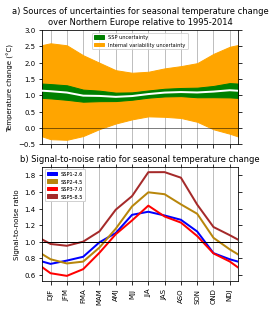

In [51]:
ls = [':', '--', '-.', '-']

for i, _index in enumerate(index_seasons_ano):
    print(_index)
    _variable, _region = _index.split('_')

    fig, ax = plt.subplots(2, 1, figsize=(single_column_width, 115*mm), sharex = True)
    for _x in range(12):
        ax[0].axvline(x=_x, c='gray', lw=.5, zorder=0)
        ax[1].axvline(x=_x, c='gray', lw=.5, zorder=0)

    # Variance arround the forced response
    plot_data = np.array([0 * index_F[_index].values, index_Fm[_index].values, index_Fs[_index].values, index_Fv[_index].values])
    labels = ['Model ('+str(len(index_seasons_ano[_index].source_id))+')', 'SSP uncertainty', 'Internal variability uncertainty']
    colors = ['blue', 'green', 'orange']
    for j in range(3):
        inf = index_mu[_index] - np.sum(plot_data[:j+2], 0)
        sup = index_mu[_index] + np.sum(plot_data[:j+2], 0)
        if (inf != sup).all():
            ax[0].fill_between(np.arange(-1,13), [inf[-1]]+list(inf)+[inf[0]], [sup[-1]]+list(sup)+[sup[0]], label=labels[j], color = colors[j], zorder=3-j)
    ax[0].plot(np.arange(-1,13),[index_mu[_index][-1]]+list(index_mu[_index])+[index_mu[_index][0]], c='w', lw='2', zorder=5)
    ax[0].set_xticks(np.arange(12))
    ax[0].set_xticklabels(seasons, rotation=90)
    ax[0].set_xlim(-0.5,11.5)
    ax[0].axhline(y=0,color='k',lw=.5)
    ax[0].set_ylabel('Temperature change (°C)')
    ax[0].legend(fontsize=5, loc='upper center')
    if _variable == 'tas':
        ax[0].set_ylim(-0.5, 3.)
    ax[0].yaxis.set_ticks_position('both')
    ax[0].set_title('a) Sources of uncertainties for seasonal temperature change\nover Northern Europe relative to 1995-2014')

    _variable, _region = _index.split('_')
    _ls = ls if len(index_seasons_ano[_index].source_id) != 1 else ['-']

    for _experiment in index_seasons_ano[_index].experiment_id.values:
        _da_delta = index_seasons_ano[_index].sel(experiment_id=_experiment).expand_dims('experiment_id')
        _da_weight = index_weight[_index].sel(member=_da_delta.member)

        # Computation of ANOVA terms: https://journals.ametsoc.org/view/journals/clim/24/17/2011jcli4085.1.xml
        _index_mu = _da_delta.weighted(_da_weight).mean(dim=('source_id', 'experiment_id', 'member'))
        _index_alpha = _da_delta.weighted(_da_weight).mean(dim=('experiment_id', 'member')) - _index_mu
        _index_beta = _da_delta.weighted(_da_weight).mean(dim=('source_id', 'member')) - _index_mu
        _index_gamma = _da_delta.weighted(_da_weight).mean(dim=('member')) + _index_mu - _index_alpha - _index_beta
        _index_nu = _da_delta - _da_delta.weighted(_da_weight).mean(dim=('member'))
        #
        _index_M = _index_alpha.var(dim=('source_id'))
        _index_S = _index_beta.var(dim=('experiment_id'))
        _index_I = _index_gamma.var(dim=('source_id', 'experiment_id'))
        _index_V = _index_nu.weighted(_da_weight).var(dim=('source_id', 'experiment_id', 'member'))
        _index_T = _index_V + _index_M + _index_S + _index_I

        # Signal-to-noise ratio: https://journals.ametsoc.org/view/journals/bams/90/8/2009bams2607_1.xml
        _index_SNR = xr.DataArray(np.array(_index_mu / conf_factor / np.sqrt(_index_T)),
                                            dims = _index_T.dims, coords = _index_T.coords)

        ax[1].plot(np.arange(-1, 13), [_index_SNR[-1]]+_index_SNR.values.tolist()+[_index_SNR[0]],
                ls=_ls[i], lw=2, c=cc.cmip6.experiment_dict[_experiment]['color'])
    ax[1].set_xticks(np.arange(12))
    ax[1].set_xticklabels(seasons, rotation=90)
    ax[1].set_xlim(-0.5, 11.5)
    yMin, yMax = ax[1].get_ylim()
    ax[1].axhline(y=1.,color='k',lw=1.)
    ax[1].yaxis.set_ticks_position('both'); ax[1].xaxis.set_ticks_position('both')
    lgd = plt.legend(handles = experiment_legend_box, fontsize=5, loc='upper left'); ax[1].add_artist(lgd)
    ax[1].set_ylabel('Signal-to-noise ratio')
    ax[1].set_title('b) Signal-to-noise ratio for seasonal temperature change')

    saveFig = figDir+saveName+'-paper_seasonal_anova_snr.pdf'
    print(saveFig)
    plt.savefig(saveFig, transparent=True)

## Figure 2

tas_NEU_land
CNRM-CM6-1
Null hypothesis: Averages are significantly different.


/Users/aline/GitHub/internal_variability_storylines/cc/plot/stats.py:57: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  _median = float(median(_tmp, weights=_weights))
/Users/aline/GitHub/internal_variability_storylines/cc/plot/stats.py:57: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  _median = float(median(_tmp, weights=_weights))
/Users/aline/GitHub/internal_variability_storylines/cc/plot/stats.py:57: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  _median = float(median(_tmp, weights=_weights))
/Users/aline/GitHub/internal_variability_storylines/cc/plot/stats.py:57: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.ilo

c,hist-ssp126,hist-ssp245,hist-ssp370,hist-ssp585,CNRM-GE
r,,,,,
hist-ssp126,100%,93%,19%,53%,80%
hist-ssp245,93%,100%,23%,48%,90%
hist-ssp370,19%,23%,100%,5%,16%
hist-ssp585,53%,48%,5%,100%,30%
CNRM-GE,80%,90%,16%,30%,100%


Null hypothesis: Sample variances are significantly different.


c,hist-ssp126,hist-ssp245,hist-ssp370,hist-ssp585,CNRM-GE
r,,,,,
hist-ssp126,100%,89%,87%,62%,92%
hist-ssp245,89%,100%,76%,52%,78%
hist-ssp370,87%,76%,100%,74%,91%
hist-ssp585,62%,52%,74%,100%,60%
CNRM-GE,92%,78%,91%,60%,100%


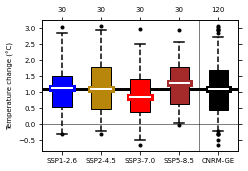

In [52]:
ccscp = reload(ccscp)

_show_mega_ensemble = True

ds_signi = xr.Dataset()
for _target in target_ano:
    if _target == 'tas_NEU_land':
        print(_target)

        _data = target_ano[_target]

        fig, ax = plt.subplots(figsize = (single_column_width, 60*mm)) # 75mm

        _tmp = list(_data.member.values); _tmp.sort()
        _dict = cc.cmip6.get_members_dict(_tmp)

        tick_positions = list()
        tick_labels = list()

        _signi_store0 = list()

        model_data = {_model: [] for _model in _dict}
        experiment_data = {_experiment: [] for _experiment in experiments}
        experiment_data_weights = {_experiment: [] for _experiment in experiments}

        for iM, _model in enumerate(_dict):
            loc_data = list()
            loc_colors = list(); loc_hatches = list()
            for i, _experiment in enumerate(experiments):
                loc_tmp = list()
                if _experiment in _dict[_model].keys():
                    for _member in _dict[_model][_experiment]:
                        loc_tmp.append(float(_data.sel(member=_member).values))
                        model_data[_model].append(float(_data.sel(member=_member).values))
                        experiment_data[_experiment].append(float(_data.sel(member=_member).values))
                        experiment_data_weights[_experiment].append(da_weight.sel(member=_member).values)
                    tick_positions.append(iM/len(_dict)+i)
                    tick_labels.append(len(_dict[_model][_experiment]))
                else:
                    loc_tmp.append(np.nan)
                loc_data.append(loc_tmp)
                loc_colors.append(cc.cmip6.experiment_dict[_experiment]['color'])
                loc_hatches.append(model_hatches[_model] if len(model) !=1 else None)
            loc_data.append(list(_data.sel(member=[_member for _member in _data.member.values if _model in _member]).values))
            loc_colors.append('k')
            loc_hatches.append(model_hatches[_model] if len(model) !=1 else None)

            ccplt.boxplot(loc_data, color = loc_colors, hatch = loc_hatches, bar = bp_median_mean, box = bp_box, ext = bp_ext,
                            dx=iM/len(_dict), width = 0.5/len(_dict))

            _signi_store1 = list()
            for iR, _sub_ref in enumerate(loc_data):
                _signi_store2 = list()
                for iT, _sub_test in enumerate(loc_data):
                    _signi_store2.append([ccscp.ttest_ind(_sub_ref, _sub_test).pvalue,
                                          ccscp.ftest_ind(_sub_ref, _sub_test).pvalue])
                _signi_store1.append(_signi_store2)
            _signi_store0.append(
                xr.DataArray(np.array(_signi_store1).transpose(),
                             name = _target,
                             dims=['test', 'r', 'c'],
                             coords={'test': ['T-test', 'F-test'], 'r':experiments+ensemble_name, 'c':experiments+ensemble_name}).assign_coords({'source_id': _model}))
        ds_signi = ds_signi.assign({_target: xr.concat(_signi_store0, dim='source_id')})
        for _model in _dict:
            print(_model)
            for _test in ds_signi.test:
                print('Null hypothesis: '+h0[str(_test.values)])
                display(ds_signi.get(_target).sel(test=_test, source_id=_model).to_pandas().style.format("{:.0%}").applymap(lambda x: color_unsignificant_red(x, significance_limit=significance_limit)))

        ax.yaxis.set_ticks_position('both')
        ax.axhline(y=0,color='k',lw=.5)
        ax.axvline(x=len(experiments)-.5,color='k',lw=.5)
        ax.set_xticks(np.arange(len(experiments)+1)+.5-0.5/len(_dict))
        ax.set_xticklabels([cc.cmip6.experiment_dict[s]['name'] for s in experiments]+ensemble_name, rotation=0) # 90
        if _show_mega_ensemble:
            ax.set_xlim([-.5/len(_dict), len(experiments)+0.5/len(_dict)])
        else:
            ax.set_xlim([-.5/len(_dict), len(experiments)-0.5/len(_dict)])
        ax.set_ylabel('Temperature change (°C)')
        if len(model) != 1:
            lgd = plt.legend(handles = model_legend_box, loc='lower left', fontsize=12)
            ax.add_artist(lgd)
            for i in range(len(experiments)+1):
                ax.axvline(x=i-0.5/len(_dict),color='k',lw=1)
        ax2 = ax.twiny()
        ax2.set_xlim(ax.get_xlim())
        tick_positions = list(np.array(tick_positions).flatten())
        tick_labels = list(np.array(tick_labels).flatten())
        if _show_mega_ensemble:
            tick_positions.append(float(len(experiments)))
            tick_labels.append(str(len(members)))
        ax2.set_xticks(tick_positions)
        ax2.set_xticklabels(tick_labels)

        ax.axhline(y=ccnp.mean(_data, weights=da_weight),color='k', lw=3,zorder=0)
        plt.savefig(figDir+saveName+'-'+_target+'_boxplot_SSP_ME.pdf', transparent=True)


## Figure 3

ShapefileException: Unable to open /data/scratch/globc/line/Data/Masks/AR6_WGI_referenceRegions/IPCC-WGI-reference-regions-v4.dbf or /data/scratch/globc/line/Data/Masks/AR6_WGI_referenceRegions/IPCC-WGI-reference-regions-v4.shp.

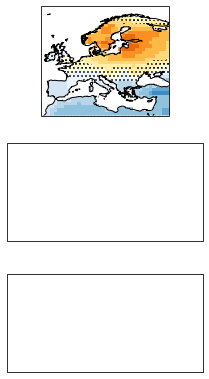

In [54]:
for _field in field_ano_raw.keys():
    if _field == 'tas':
        fig, ax = plt.subplots(story.ndrivers + 1, 1, figsize = (single_column_width, 170*mm), subplot_kw=dict(projection=ccrs.PlateCarree())) #, width_ratios=[1, 1]) # 210mm
        nbins=21
        cmap_params = {'vmin': -1, 'vmax': 1}
        _row_length = 10
        for iD, _driver in enumerate(list(driver_ano.keys())[::-1]):
            _x = driver_ano.get(_driver); _y = field_ano_raw.get(_field)
            _X = (_x - _x.mean()) / _x.std()
            slope_list = list(); pvalue_list = list()
            for _lat in _y.lat.sel(lat=slice(zone[2]-1, zone[3]+1)).values:
                slope_list_lat = list(); pvalue_list_lat = list()
                for _lon in _y.lon.sel(lon=slice(zone[0]-1, zone[1]+1)).values:
                    if _y[0].sel(lat=_lat, lon=_lon):
                        _Y = _y.sel(lat=_lat, lon=_lon)
                        _slope, _, _rvalue, _pvalue, _ = scipy.stats.linregress(_X, _Y)
                        _slope = xr.DataArray([[_slope]], dims=['lat', 'lon'], coords = {'lat': [_lat], 'lon': [_lon]})
                        _pvalue = 2.*(1.-scipy.stats.t.cdf(abs(scipy.stats.t.ppf(_pvalue/2., 119)), 30))
                        _pvalue = xr.DataArray([[_pvalue]], dims=['lat', 'lon'], coords = {'lat': [_lat], 'lon': [_lon]})
                    else:
                        _slope = xr.DataArray([[np.nan]], dims=['lat', 'lon'], coords = {'lat': [_lat], 'lon': [_lon]})
                        _pvalue = xr.DataArray([[np.nan]], dims=['lat', 'lon'], coords = {'lat': [_lat], 'lon': [_lon]})
                    slope_list_lat.append(_slope)
                    pvalue_list_lat.append(_pvalue)
                slope_list.append(xr.concat(slope_list_lat, dim='lon'))
                pvalue_list.append(xr.concat(pvalue_list_lat, dim='lon'))
            slope = xr.concat(slope_list, dim='lat')
            pvalue = xr.concat(pvalue_list, dim='lat')

            vmax = .9
            vmin = -vmax
            cs = cc.maplot(slope, ax = ax[iD], zmin=vmin, zmax=vmax, nbins=nbins, cmap=ccmp.get_diverging_cmap(**cmap_params), plotmode='raster', significance=pvalue, hide_ax_labels=True)
            ax[iD].coastlines()
            ax[iD].set_extent(zone)

            if show_box is not None:
                for _region in show_box:
                    if _region in ['FRA']:
                        shape_file = inDir+'/personal_shapes.shp'
                    else:
                        shape_file = inDir+'/AR6_WGI_referenceRegions/IPCC-WGI-reference-regions-v4.shp'
                    bx = ccmps.plot_shape(shape_file=shape_file, name=_region, ax = ax[iD], color='k', linestyle='-', linewidth=3, zorder=None, disp_name= 'tl')

            ax[iD].set_title(subfigure_label[iD]+r"Regression pattern of "+delta_print+target_dict[_field]+" on "+delta_print+_driver, fontsize=8)
        
        cbar = fig.colorbar(cs, ax=ax[:-1], label='Temperature anomalies (°C/$\sigma_{driver}$)', orientation='vertical', fraction=.05, shrink=.75, aspect=40, extend = 'neither')
        cbar.ax.tick_params(labelsize=5)

        nbins = 11
        _diff_contour = .5
        cmap_params = {'vmin': 0., 'vmax': 100.}
        cmap_loc = ccmp.get_diverging_cmap(**cmap_params)
        ax[-1].coastlines()
        ax[-1].set_extent(zone)
        cs = cc.maplot(
            field_exp_var.get(_field)*100.,
            ax = ax[-1], cmap = 'BuGn',
            zmin=cmap_params['vmin'], zmax=cmap_params['vmax'], nbins=nbins, plotmode='raster', hide_ax_labels=True)
        if show_box is not None:
            for _region in show_box:
                if _region in ['FRA']:
                    shape_file = inDir+'/personal_shapes.shp'
                else:
                    shape_file = inDir+'/AR6_WGI_referenceRegions/IPCC-WGI-reference-regions-v4.shp'
                bx = ccmps.plot_shape(shape_file=shape_file, name=_region, ax = ax[-1], color='k', linestyle='-', linewidth=3, zorder=None, disp_name= 'tl')
        ax[-1].set_title(subfigure_label[story.ndrivers]+r"Variance of "+delta_print+target_dict[_field]+" explained by "+delta_print+str(" & "+delta_print).join(story.drivers), fontsize=8)
        cbar = fig.colorbar(cs, ax=ax[-1], label='Percentage (%)', orientation='vertical', fraction=.05, shrink=.75, extend = 'neither')
        cbar.ax.tick_params(labelsize=5)

        plt.savefig(figDir+saveName+'-'+_field+'_map_regressions_explained_variance.pdf', transparent=True)

## Figure 4

tas_NEU_land


/Users/aline/GitHub/internal_variability_storylines/cc/plot/stats.py:57: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  _median = float(median(_tmp, weights=_weights))
/Users/aline/GitHub/internal_variability_storylines/cc/plot/stats.py:57: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  _median = float(median(_tmp, weights=_weights))
/Users/aline/GitHub/internal_variability_storylines/cc/plot/stats.py:57: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  _median = float(median(_tmp, weights=_weights))
/Users/aline/GitHub/internal_variability_storylines/cc/plot/stats.py:57: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.ilo

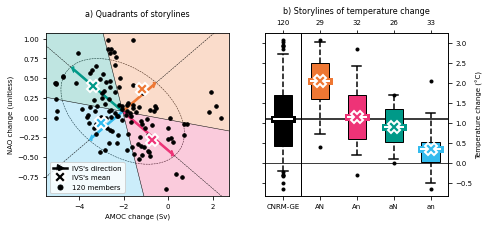

In [ ]:
if len(drivers) == 2:
    for _target in target_ano.keys():
        if _target == 'tas_NEU_land':
            print(_target)

            _data = target_ano[_target]
            _me_avg = ccnp.mean(_data, weights=da_weight.sel(member=_data.member))
            _me_std = ccnp.std(_data, weights=da_weight.sel(member=_data.member))

            fig, ax = plt.subplots(1,2, figsize = (double_column_width, 75*mm), width_ratios=[1, 1]) # (double_column_width, 90*mm)

            ax[0].set_title("a) Quadrants of storylines\n", fontsize=8)
            ax[1].set_title("b) Storylines of temperature change", fontsize=8)

            ax[0].set_xlabel(delta_print+list(main_driver_ano.data_vars)[0]); ax[0].set_ylabel(delta_print+list(main_driver_ano.data_vars)[1])
            story.plot_quadrants(ax=ax[0], show_members=True, show_stories=False, markersize=7) # markersize=12
            ax[0].set_xlabel('AMOC change (Sv)')
            ax[0].set_ylabel('NAO change (unitless)')

            _yMin, _yMax = ax[0].get_ylim()
            _Xreg, _Xinter, _, _, _ = scipy.stats.linregress(
                [story.outputs.storindex[0,1], story.outputs.storindex[3,1]],
                [story.outputs.storindex[0,0], story.outputs.storindex[3,0]])
            ax[0].plot([_Xinter + _Xreg * _yMin, _Xinter + _Xreg * _yMax], [_yMin, _yMax],
                    c = 'k', lw = .5, ls = '--', zorder = 1)
            _Xreg, _Xinter, _, _, _ = scipy.stats.linregress(
                [story.outputs.storindex[1,1], story.outputs.storindex[2,1]],
                [story.outputs.storindex[1,0], story.outputs.storindex[2,0]])
            ax[0].plot([_Xinter + _Xreg * _yMin, _Xinter + _Xreg * _yMax], [_yMin, _yMax],
                    c = 'k', lw = .5, ls = '--', zorder = 1)
            '''
            -> : Storyline direction
            X : AN mean
            o : 120 members
            '''
            ax[0].legend(
                [
                    mlines.Line2D([0], [0], marker='>', ls='-', color='k', lw=2.5, markersize=7),
                    mlines.Line2D([0], [0], marker='X', ls='', color='k', mec='w', mew = 2, markersize=12),
                    mlines.Line2D([0], [0], marker='o', ls='', color='k', markersize=5),
                ],
                ["IVS's direction", "IVS's mean", str(len(members))+' members'],
                fontsize=7
            )

            tick_positions = list(); tick_labels = list()
            ax[1].yaxis.set_ticks_position('both')
            ax[1].axhline(y=0,color='k',lw=.5)
            tick_labels.append(len(_data.member))

            for iS, _sto in enumerate(story.labels):
                _story_members = list(set(story.families[story.stories[iS]]['label']).intersection(set(_data.member.values)))
                ax[0].arrow(main_driver_ano.get(list(main_driver_ano.data_vars)[0]).weighted(da_weight).mean(), main_driver_ano.get(list(main_driver_ano.data_vars)[1]).weighted(da_weight).mean(),
                            story.outputs.storindex[iS,0]-main_driver_ano.get(list(main_driver_ano.data_vars)[0]).weighted(da_weight).mean(),
                            story.outputs.storindex[iS,1]-main_driver_ano.get(list(main_driver_ano.data_vars)[1]).weighted(da_weight).mean(),
                            color = story.colors[iS], width=.025, length_includes_head=True)
                ax[0].plot(main_driver_ano.get(list(main_driver_ano.data_vars)[0]).sel(member=_story_members).weighted(da_weight.sel(member=_story_members)).mean(),
                        main_driver_ano.get(list(main_driver_ano.data_vars)[1]).sel(member=_story_members).weighted(da_weight.sel(member=_story_members)).mean(),
                        marker = 'X', mec = 'w', c = story.colors[iS], ms=12, mew = 2, zorder=3) # ms=20
                ccplt.boxplot([_data.sel(member=_story_members)],
                            weights = [da_weight.sel(member=_story_members)],
                            color = [story.colors[iS]],
                            bar = bp_median_mean, box = bp_box, ext = bp_ext,
                            dx=1+iS, width = 0.5)
                tick_labels.append(len(_story_members))
                _pred = story.story_predict(_target)
                if normalisation_method == 'std':
                    _pred = _pred*_me_std+_me_avg
                ax[1].plot(iS+1, _data.sel(member=_story_members).weighted(da_weight.sel(member=_story_members)).mean(),
                        marker = 'X', c = story.colors[iS], ms=12, mec = 'w', mew = 2, zorder=3) # ms=20

            ccplt.boxplot([_data], weights = [da_weight.sel(member=_data.member.values)], ax = ax[1],
                        bar = bp_median_mean, box = bp_box, ext = bp_ext, width = 0.5)
            ax[1].axhline(y=ccnp.mean(_data, weights=da_weight.sel(member=_data.member.values)),color='k', zorder=0)

            ax[1].axhline(y=0,color='k',lw=.5)
            ax[1].set_xticks(np.arange(1+len(story.stories)))
            ax[1].set_xticklabels(
                ensemble_name+story.stories,
                rotation=0)
            ax[1].set_ylabel('Temperature change (°C)')
            ax[1].yaxis.tick_right(); ax[1].yaxis.set_label_position("right"); ax[1].yaxis.set_ticks_position('both')
            ax2 = ax[1].twiny()
            ax2.set_xlim(ax[1].get_xlim())
            ax2.set_xticks(np.arange(1+len(story.stories)))
            ax2.set_xticklabels(tick_labels)
            ax[1].axvline(x=0.5,color='k',lw=1)
            plt.savefig(figDir+saveName+'-'+_target+'_quadrant_boxplot_ME_story.pdf', transparent=True)

## Figure 5

In [ ]:
nbins = 21
_diff_contour = .5
cmap_params = {'vmin': -1., 'vmax': 1.}
if story.ndrivers == 1:
    n_row=1; n_col=2
elif story.ndrivers == 2:
    n_row=2; n_col=2
elif story.ndrivers == 3:
    n_row=3; n_col=3
figsize = (extended_width, 100*mm)

for field_data, _norm in [[field_ano_raw, 'raw']]:
    for _field in field_ref:
        if _field == 'tas':

            _da_field = field_data[_field].sel(lat=slice(zone[2]-1, zone[3]+1), lon=slice(zone[0]-1, zone[1]+1))

            if _norm == 'std':
                cmap_params = {'vmin': -1., 'vmax': 1.}
                replace_in = '$\\Delta$'; replace_out = '$\\tilde{\\Delta}$'
            else:
                if _field == 'tas':
                    cmap_params = {'vmin': -1., 'vmax': 2.}
                elif _field in ('pr', 'prsn', 'prlq'):
                    cmap_params = {'vmin': -.5, 'vmax': .5, 'neg': 'YlOrBr', 'pos': 'YlGnBu'}
                elif _field in ('sfcWind'):
                    cmap_params = {'vmin': -.25, 'vmax': .25, 'neg': 'YlOrBr', 'pos': 'YlGnBu'}
                else:
                    cmap_params = {'vmin': -1., 'vmax': 1.}
                replace_in = '$\\tilde{\\Delta}$'; replace_out = '$\\Delta$'
            cmap_loc = ccmp.get_diverging_cmap(**cmap_params)

            fig, ax = plt.subplots(n_row, n_col, figsize = figsize, subplot_kw = dict(projection=ccrs.PlateCarree())) #, gridspec_kw={'width_ratios': [3, 1]})
            fig.subplots_adjust(hspace=0.2,wspace=0.2)

            for iS, _sto in enumerate(story.stories):
                _story_members = list(set(story.families[story.stories[iS]]['label']).intersection(set(_da_field.member.values)))
                _tmp = _da_field.sel(member=_story_members).weighted(da_weight.sel(member=_story_members))

                if story.ndrivers == 1:
                    if iS == 0:
                        _plot_shape = True; _ax = ax[0]; _sfl = 0
                    elif iS == 1:
                        _plot_shape = False; _ax = ax[1]; _sfl = 1
                elif story.ndrivers == 2:
                    if iS == 0:
                        _plot_shape = False; _ax = ax[0,1]; _sfl = 1
                        #_plot_shape = False; _ax = ax[0,1]; _sfl = 1
                    elif iS == 1:
                        _plot_shape = False; _ax = ax[1,1]; _sfl = 3
                        #_plot_shape = False; _ax = ax[1,0]; _sfl = 2
                    elif iS == 2:
                        _plot_shape = True; _ax = ax[0,0]; _sfl = 0
                        #_plot_shape = False; _ax = ax[1,1]; _sfl = 3
                    elif iS == 3:
                        _plot_shape = False; _ax = ax[1,0]; _sfl = 2
                        #_plot_shape = True; _ax = ax[0,0]; _sfl = 0
                elif story.ndrivers == 3:
                    if iS == 0:
                        _plot_shape = True; _ax = ax[0,0]; _sfl = 1
                    elif iS < 4:
                        _plot_shape = False; _ax = ax[iS//n_col, iS%n_col]; _sfl = iS
                    elif iS >= 4:
                        _plot_shape = False; _ax = ax[(iS+1)//n_col, (iS+1)%n_col]; _sfl = iS
                    ax[1,1].axis('off')

                _ax.coastlines()
                _ax.set_extent(zone)
                cs = cc.maplot(
                    _tmp.mean(dim='member'),
                    significance=field_sto_diff_signi.get(_field).sel(story=story.stories[iS]),
                    ax = _ax, cmap = cmap_loc, zmin=cmap_params['vmin'], zmax=cmap_params['vmax'], nbins=nbins, plotmode='raster', hide_ax_labels=True)
                _ax.set_title(subfigure_label[_sfl]+_sto+' IVS', fontsize=8)
                _ax.spines['geo'].set(edgecolor=story.colors[iS], linewidth=2)

                if show_box is not None:
                    for _region in show_box:
                        if _region in ['FRA']:
                            shape_file = '/data/scratch/globc/line/Data/Masks/personal_shapes.shp'
                        else:
                            shape_file = '/data/scratch/globc/line/Data/Masks/AR6_WGI_referenceRegions/IPCC-WGI-reference-regions-v4.shp'
                        bx = ccmps.plot_shape(shape_file=shape_file, name=_region, ax = _ax, color='k', linestyle='-', linewidth=3, zorder=None, disp_name= False if len(show_box) == 1 else True)

            fig.colorbar(cs, ax=ax, label='Temperature change (°C)', orientation='vertical', fraction=.05, shrink=.75, aspect=40, extend = 'neither')

            plt.savefig(figDir+saveName+'-maps_'+_field+'_'+_norm+'_story_signi_to_ref_raster'+figExt,transparent=True)
            plt.show()

KeyError: 'tas'

In [ ]:
field_data

{}

## Figure 6

snc_NEU_land  
-3.211 x - 0.6513
prsn_NEU_land  
-0.8972 x + 1.054
prlq_NEU_land  
9.816 x + 1.46
pr_NEU_land  
3.117 x + 1.352
sfcWind_NEU_land  
0.6057 x + 0.6935
rsds_NEU_land  
-0.9653 x + 0.9344


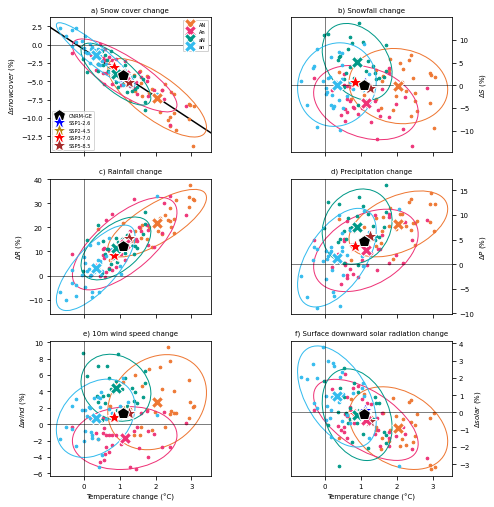

In [ ]:
import math

_region = 'NEU'
_variable = 'tas'

fig, ax = plt.subplots(3, 2, figsize = (double_column_width, 210*mm), # (extended_width, 170*mm), #
                       sharex=True, sharey=False)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
for i, _target in enumerate(['snc_NEU_land', 'prsn_NEU_land', 'prlq_NEU_land', 'pr_NEU_land', 'sfcWind_NEU_land', 'rsds_NEU_land']):
    _ax=ax[i//2, i%2]
    if i%2 == 1:
        _ax.yaxis.set_label_position('right')
        _ax.yaxis.tick_right()
    if _variable+'_' not in _target and _region in _target:
        _Y = main_target_ano.get(_target)
        _X = main_target_ano.get(_variable+'_'+_region+'_land').sel(member = _Y.member)
        _da_weight = da_weight.sel(member=_Y.member)
        _ax.plot(ccnp.mean(_X, weights=_da_weight), ccnp.mean(_Y, weights=_da_weight), ls='',
                    ms = 13, marker = 'p', c = 'k', label=ensemble_name[0], mec='w', zorder=7)
        if len(experiments) != 1:
            for _experiment in experiments:
                _members_expriment = [_member for _member in _Y.member.values if _experiment in _member]
                _ax.plot(ccnp.mean(_X.sel(member = _members_expriment), weights=_da_weight.sel(member=_members_expriment)),
                            ccnp.mean(_Y.sel(member = _members_expriment), weights=_da_weight.sel(member=_members_expriment)),
                            ms = 15, marker = '*', c = cc.cmip6.experiment_dict[_experiment]['color'], ls='',
                            label=experiment_labels[_experiment], mec='w', zorder=5)
        for iS, _sto in enumerate(story.families):
            for _model in members_dict.keys():
                _story_members_model = list(set([_member for _member in story.families[_sto]['label'] if _model in _member]).intersection(set(list(_Y.member.values))))
                _ax.scatter(_X.sel(member=_story_members_model),
                            _Y.sel(member=_story_members_model),
                            s = 7, c = story.colors[iS], marker = model_markers[_model])
                _ax.plot(_X.sel(member=_story_members_model).mean(), _Y.sel(member=_story_members_model).mean(),
                            ms = 12, marker = 'X', c = story.colors[iS], ls='', mec='w', zorder=5) # , label=story.stories[iS]
                ccplt.confidence_ellipse(_X.sel(member=_story_members_model), _Y.sel(member=_story_members_model),
                                        ax=_ax, n_std=2., edgecolor=story.colors[iS])
        _ax.set_title(subfigure_label[i]+cc.cmip6.name_dict[_target.split('_')[0]].capitalize()+' change', fontsize=7)
        xMin, xMax = _ax.get_xlim(); _ax.set_xlim(xMin, xMax); yMin, yMax = _ax.get_ylim(); xMin2, xMax2 = _ax.get_xlim(); _ax.set_xlim(xMin2, xMax2)
        if xMin < 0. and xMax > 0.:
            _ax.axvline(x=0, color='k', lw=.5)
        if yMin < 0. and yMax > 0.:
            _ax.axhline(y=0, color='k', lw=.5)
        if i//2 == 2:
            _ax.set_xlabel(cc.cmip6.name_dict[_variable].capitalize()+' '+anomaly_name+' (°C)')
        _ax.set_ylabel(_ylabel[_target.split('_')[0]]+' ('+_Y.attrs['units']+')')

        p = np.poly1d(np.polyfit(_X, _Y, 1))
        print(_target, p)
        if _target == 'snc_NEU_land':
            _ax.plot(np.linspace(xMin2, xMax2, 100), p(np.linspace(xMin2, xMax2, 100)), 'k-', zorder=0) # 'k--'
lgd = ax[0,0].legend(loc='lower left', fontsize=5)
ax[0,0].add_artist(lgd)
lgd_sto = ax[0,0].legend(handles = story_legend_cross, loc='upper right', fontsize=5)
ax[0,0].add_artist(lgd_sto)

plt.savefig(figDir+saveName+'-tas_physical_consistency'+figExt,transparent=True)

## Figure 7

tas_NEU_land
   CNRM-GE  170 +0.9
        AN 1731 +2.2
        an   73 +0.3



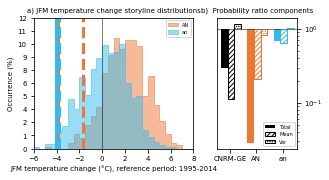

In [ ]:
p_test = 0.1
distrib_fit = None

p_test = 0.02; distrib_fit = 'normal'

hatches = (None, '/////', '.....')
_colors = ['black'] + ['#EE7733', '#33BBEE']

for _target in ['tas_NEU_land']:
    print(_target)
    _relative = True if relative and _target.split('_')[0] in cc.cmip6.relative_variables else False

    _bins_per_unit = 2
    _range = (-6., 8.); _nbins = int((_range[1]-_range[0]) * _bins_per_unit)

    fig, ax = plt.subplots(1, 2, figsize=(extended_width, 60*mm), width_ratios=(2, 1))

    ax[0].axvline(x=0, ls='-', c='k', lw=.5)
    ax[0].set_title(subfigure_label[0]+temporality+' temperature change storyline distributions', fontsize=7)
    ax[0].set_xlabel(temporality+' temperature change (°C), reference period: '+refStr+'-'+refEnd)
    ax[0].set_ylabel('Occurrence (%)')
    ax[0].tick_params(axis='both', which='major')

    ax[0].set_xlim(_range); ax[0].set_ylim((0.0, 7.0/_nbins)) # 10.0/_nbins
    ax[0].yaxis.set_major_formatter(PercentFormatter(xmax=_nbins/(_range[1]-_range[0]), decimals=0, symbol=0))
    ax[0].locator_params(axis='y', nbins=10)
    _xlims= ax[0].get_xlim(); _ylims= ax[0].get_ylim()
    
    ax[1].set_title(subfigure_label[1]+' Probability ratio components', fontsize=7)
    ax[1].axhline(y=1., lw=.5, c='k'); ax[1].set_yscale('log')
    ax[1].set_xticks(np.arange(3)+1./3.)
    ax[1].set_xticklabels(['CNRM-GE', 'AN', 'an'])
    ax[1].yaxis.set_label_position('right')
    ax[1].yaxis.tick_right()
    iS=0
    for i, _ens in enumerate(['CNRM-GE', 'AN', 'an']):
        _members = dict_of_members[_ens]
        _da_intann_ref = intann_ref[_target].sel(member=_members).stack(sample=('member', 'time'))
        _da_intann_int = intann_int[_target].sel(member=_members).stack(sample=('member', 'time'))
        _da_weight_ref = da_weight.expand_dims({'time': intann_ref[_target].time}).stack(sample=('member', 'time')).sel(sample=_da_intann_ref.sample)
        _da_weight_int = da_weight.expand_dims({'time': intann_int[_target].time}).stack(sample=('member', 'time')).sel(sample=_da_intann_int.sample)
        _new_p, _delta_intensity = ccxtr.compare_extreme_events(
            _da_intann_ref,
            _da_intann_int,
            p=p_test, distrib_fit=distrib_fit, relative=_relative,
            weights_x = _da_weight_ref, weights_y = _da_weight_int)
        if bootstrap:
            _new_p_boot_list, _delta_intensity_boot_list = list(), list()
            for iB in range(1, n_boot+1):
                _new_p_boot, _delta_intensity_boot = ccxtr.compare_extreme_events(
                    intann_boot[_target+'_'+_ens+'_ref'].sel(boot=iB),
                    intann_boot[_target+'_'+_ens+'_int'].sel(boot=iB),
                    p=p_test, distrib_fit=distrib_fit, relative=_relative)
                _new_p_boot_list.append(_new_p_boot); _delta_intensity_boot_list.append(_delta_intensity_boot)
            print('{:>10}'.format(_ens),
                  '{:4d}'.format(round(1./_new_p)),
                  '[{:4d}'.format(round(1./np.quantile(_new_p_boot_list, int_high)))+' — '+'{:4d}],'.format(round(1./np.quantile(_new_p_boot_list, int_low))),
                  '{0:+.1f}'.format(_delta_intensity),
                  '[{0:+.1f}'.format(np.quantile(_delta_intensity_boot_list, int_low))+' — '+'{0:+.1f}]'.format(np.quantile(_delta_intensity_boot_list, int_high)))
        else:
            print('{:>10}'.format(_ens),
                  '{:4d}'.format(round(1./_new_p)),
                  '{0:+.1f}'.format(_delta_intensity))
        _pr, _r = ccxtr.probability_ratio_percentile(
            _da_intann_ref,
            _da_intann_int,
            p=p_test, distrib_fit=distrib_fit,
            weights_x = _da_weight_ref, weights_y = _da_weight_int)
        if _ens == ensemble_name[0]:
            c='k'; iS+=1
        else:
            c = _colors[i]
        if _ens not in (ensemble_name[0], 'An', 'aN'):
            _x = list()
            for _intann in (_da_intann_ref.weighted(_da_weight_ref), _da_intann_int.weighted(_da_weight_int)):
                if True:
                    _x.append(scipy.stats.norm.ppf(p_test, loc=_intann.mean(), scale=_intann.std()))
                else:
                    _x.append(np.quantile(_intann.values, p_test))
            ax[0].axvline(x=_x[0], color=c, lw=3)
            ax[0].hist(_da_intann_int, weights=_da_weight_int,
                       density=True, bins=_nbins, range=_range,
                       histtype='stepfilled', alpha=0.5, color=c,
                       edgecolor=c, label=_ens)
            ax[0].axvline(x=_x[1], color=c, lw=3, ls='--')
        _labels = ('Total', 'Mean', 'Var') if i == 0 else (None, None, None)
        for j in range(3):
            _c, _fill, _hatch = (c, True, None) if j == 0 else ('w', False, hatches[j])
            ax[1].stairs([_pr[j]], [i+j/4,i+(j+1)/4], baseline=1.,
                         fill=_fill, color=_c, hatch=_hatch, ec=c, label=_labels[j])
    ax[0].legend(fontsize=5); ax[1].legend(loc='lower right', fontsize=5)
    plt.savefig(figDir+saveName+'-'+_target+'_analog_distribution_probability_ratio.pdf', transparent=True)
    print()

## Figure 9

tas_NEU_land 
 SNR: 0.75, forced response: 1.08, total uncertainty: 1.45 (storyline: 54%, uncaptured internal variability: 43%, model: 0%, scenario: 3%).
pr_NEU_land 
 SNR: 0.56, forced response: 4.73, total uncertainty: 8.45 (storyline: 40%, uncaptured internal variability: 58%, model: 0%, scenario: 2%).
prlq_NEU_land 
 SNR: 0.70, forced response: 12.09, total uncertainty: 17.36 (storyline: 47%, uncaptured internal variability: 47%, model: 0%, scenario: 6%).
prsn_NEU_land 
 SNR: 0.01, forced response: 0.08, total uncertainty: 8.68 (storyline: 39%, uncaptured internal variability: 60%, model: 0%, scenario: 1%).
snc_NEU_land 
 SNR: -0.79, forced response: -4.13, total uncertainty: 5.21 (storyline: 49%, uncaptured internal variability: 45%, model: 0%, scenario: 6%).
sfcWind_NEU_land 
 SNR: 0.25, forced response: 1.35, total uncertainty: 5.34 (storyline: 51%, uncaptured internal variability: 48%, model: 0%, scenario: 1%).
rsds_NEU_land 
 SNR: -0.05, forced response: -0.11, total uncertain

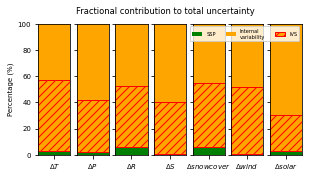

In [ ]:
ccmp = reload(ccmp)

begin = time.time()

width=.5

target_mu = dict(); target_std = dict()
target_model = xr.Dataset(); target_alpha = dict(); target_gamma = dict()
target_ssp = xr.Dataset(); target_beta = dict()
target_story = xr.Dataset(); target_sigma = dict(); target_delta = dict(); target_epsilon = dict(); target_zeta = dict()
target_iv = xr.Dataset(); target_nu =dict()

fig, ax = plt.subplots(1, 7, figsize=(extended_width, 60*mm), sharey = True) # (double_column_width,75*mm)

for i, _target in enumerate([
    'tas_NEU_land',
    'pr_NEU_land',
    'prlq_NEU_land',
    'prsn_NEU_land',
    'snc_NEU_land',
    'sfcWind_NEU_land',
    'rsds_NEU_land',
    ]):
    _tmp = target_ano[_target]
    _conf_factor = scipy.stats.t.ppf(1.-(1.-confidence_range)/2., len(_tmp.member))
    #print(_conf_factor)

    target_mu[_target] = _tmp.sortby('member').weighted(da_weight.sel(member=_tmp.member).sortby('member')).mean(dim='member')
    target_std[_target] = _tmp.sortby('member').weighted(da_weight.sel(member=_tmp.member).sortby('member')).std(dim='member')

    _avg = list()
    for _model in model:
        _da_target = _tmp.sel(member=[_member for _member in _tmp.member.values if _model in _member]).sortby('member')
        _da_weight = da_weight.sel(member=_da_target.member).sortby('member')
        _avg.append(
            _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'source_id':_model})
            - target_mu[_target])
    target_alpha[_target] = xr.concat(_avg, dim='source_id')

    _avg = list()
    for _experiment in experiments:
        _da_target = _tmp.sel(member=[_member for _member in _tmp.member.values if _experiment in _member]).sortby('member')
        _da_weight = da_weight.sel(member=_da_target.member).sortby('member')
        _avg.append(
            _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'experiment_id':_experiment})
            - target_mu[_target])
    target_beta[_target] = xr.concat(_avg, dim='experiment_id')

    _avg = list()
    for _sto in story.stories:
        _da_target = _tmp.sel(member=[_member for _member in story.families[_sto]['label'] if _member in _tmp.member.values]).sortby('member')
        _da_weight = da_weight.sel(member=_da_target.member).sortby('member')
        _avg.append(
            _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'storyline':_sto})
            - target_mu[_target])
    target_sigma[_target] = xr.concat(_avg, dim='storyline')

    _avg = list()
    for _model in model:
        _model_list = list()
        for _experiment in experiments:
            if _experiment in members_dict[_model]:
                _members = [_member for _member in _tmp.member.values if _model+'_'+_experiment in _member]
                _da_target = _tmp.sel(member=_members).sortby('member')
                _da_weight = da_weight.sel(member=_members).sortby('member')
                _model_list.append(
                    _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'source_id':_model, 'experiment_id':_experiment})
                    - target_alpha[_target].sel(source_id=_model)
                    - target_beta[_target].sel(experiment_id=_experiment)
                    + target_mu[_target])
            else:
                _model_list.append(xr.full_like(target_mu[_target], np.nan).assign_coords({'source_id':_model, 'experiment_id':_experiment}))
        _avg.append(xr.concat(_model_list, dim='experiment_id'))
    target_gamma[_target] = xr.concat(_avg, dim='source_id')

    _avg = list()
    for _model in model:
        _model_list = list()
        for _sto in story.stories:
            _members = [_member for _member in story.families[_sto]['label'] if _model in _member and _member in _tmp.member.values]
            _da_target = _tmp.sel(member=_members).sortby('member')
            _da_weight = da_weight.sel(member=_members).sortby('member')
            _model_list.append(
                _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'source_id':_model, 'storyline':_sto})
                - target_alpha[_target].sel(source_id=_model)
                - target_sigma[_target].sel(storyline=_sto)
                + target_mu[_target])
        _avg.append(xr.concat(_model_list, dim='storyline'))
    target_delta[_target] = xr.concat(_avg, dim='source_id')

    _avg = list()
    for _experiment in experiments:
        _expe_list = list()
        for _sto in story.stories:
            _members = [_member for _member in story.families[_sto]['label'] if _experiment in _member and _member in _tmp.member.values]
            _da_target = _tmp.sel(member=_members).sortby('member')
            _da_weight = da_weight.sel(member=_members).sortby('member')
            _expe_list.append(
                _da_target.weighted(_da_weight).mean(dim='member').assign_coords({'experiment_id':_experiment, 'storyline':_sto})
                - target_beta[_target].sel(experiment_id=_experiment)
                - target_sigma[_target].sel(storyline=_sto)
                + target_mu[_target])
        _avg.append(xr.concat(_expe_list, dim='storyline'))
    target_epsilon[_target] = xr.concat(_avg, dim='experiment_id')

    _tmp_member = list(main_target_ano[_target].member.values); _tmp_member.sort(); _dict = cc.cmip6.get_members_dict(_tmp_member)
    _res = list(); _inter = list()
    for _model in _dict.keys():
        _inter_model = list()
        for _experiment in experiments:
            _inter_expe = list()
            for _sto in story.stories:
                _members = [_member for _member in story.families[_sto]['label'] if _model+'_'+_experiment in _member and _member in _tmp.member.values]
                _da_target = _tmp.sel(member=_members).sortby('member')
                _da_weight = da_weight.sel(member=_members).sortby('member')
                _res.append(_da_target - _da_target.weighted(_da_weight).mean(dim='member'))
                _inter_expe.append(_da_target.weighted(_da_weight).mean(dim='member').assign_coords({'source_id':_model, 'experiment_id':_experiment, 'storyline':_sto})
                                   - target_alpha[_target].sel(source_id=_model)
                                   - target_beta[_target].sel(experiment_id=_experiment)
                                   - target_gamma[_target].sel(source_id=_model, experiment_id=_experiment)
                                   - target_delta[_target].sel(source_id=_model, storyline=_sto)
                                   - target_epsilon[_target].sel(experiment_id=_experiment, storyline=_sto)
                                   - target_sigma[_target].sel(storyline=_sto)
                                   - target_mu[_target])
            _inter_model.append(xr.concat(_inter_expe, dim='storyline'))
        _inter.append(xr.concat(_inter_model, dim='experiment_id'))
    target_zeta[_target] = xr.concat(_inter, dim='source_id')
    target_nu[_target] = xr.concat(_res, dim='member').sortby('member')

    _da_weight = da_weight.sel(member=_tmp.member).sortby('member')

    _var_tot = (
        target_nu[_target].weighted(_da_weight).var(dim='member')
        + target_alpha[_target].var(dim='source_id')
        + target_beta[_target].var(dim='experiment_id')
        + target_gamma[_target].var(dim=('source_id', 'experiment_id'))
        + target_delta[_target].var(dim=('source_id', 'storyline'))
        + target_epsilon[_target].var(dim=('experiment_id', 'storyline'))
        + target_zeta[_target].var(dim=('source_id', 'experiment_id', 'storyline'))
        + target_sigma[_target].var(dim='storyline')
    )
    _total_uncertainty = _conf_factor*(_var_tot)**.5
    _total_uncertainty = _conf_factor*target_std[_target]
    _snr = target_mu[_target] / _total_uncertainty

    target_iv = target_iv.assign({_target: xr.DataArray((
            target_nu[_target].weighted(_da_weight).var(dim='member')
        ) / _var_tot)})
    target_model = target_model.assign({_target: xr.DataArray((
            target_alpha[_target].var(dim='source_id')
            + target_gamma[_target].var(dim=('source_id', 'experiment_id'))
        ) / _var_tot)})
    target_ssp = target_ssp.assign({_target: xr.DataArray((
            target_beta[_target].var(dim='experiment_id')
        ) / _var_tot)})
    target_story = target_story.assign({_target: xr.DataArray((
            target_sigma[_target].var(dim='storyline')
            + target_delta[_target].var(dim=('source_id', 'storyline'))
            + target_epsilon[_target].var(dim=('experiment_id', 'storyline'))
            + target_zeta[_target].var(dim=('source_id', 'experiment_id', 'storyline'))
        ) / _var_tot)})

    print(
        _target,'\n',
        'SNR: {0:.2f},'.format(_snr.values),
        'forced response: {0:.2f},'.format(target_mu[_target].values),
        'total uncertainty: {0:.2f}'.format(_total_uncertainty.values),
        '(storyline: {0:.0f}%,'.format(100.*target_story[_target].values),
        'uncaptured internal variability: {0:.0f}%,'.format(100.*target_iv[_target].values),
        'model: {0:.0f}%,'.format(100.*target_model[_target].values),
        'scenario: {0:.0f}%).'.format(100.*target_ssp[_target].values),
    )
    import matplotlib.patches
    _boxlow = 0.
    _ax = ax if len(main_target_ano) == 1 else ax[i]
    for _src, _clr, _htc, _edc in [
        [target_model[_target], 'blue', None, None],
        [target_ssp[_target], 'green', None, None],
        [target_story[_target], 'orange', '///', 'red'],
        [target_iv[_target], 'orange', None, None]
    ]:
        _boxhigh = _boxlow + 100.*_src.values
        _ax.add_patch(matplotlib.patches.Rectangle(
            (0, _boxlow), width, _boxhigh-_boxlow,
            facecolor = _clr, hatch = _htc, edgecolor = _edc))
        _boxlow = _boxhigh
    _ax.set_xlim(0., width)
    _ax.set_ylim(0., 100)
    _ax.set_xticks([width/2.])
    _ax.set_xticklabels([_ylabel[_target.split('_')[0]]])

ax[0].set_ylabel('Percentage (%)')

ax[-1].legend(
    [
        mpatches.Patch(facecolor='green', edgecolor=None),
        mpatches.Patch(facecolor='orange', edgecolor=None),
        mpatches.Patch(facecolor='orange', hatch='///', edgecolor='red'),
    ],
    ['SSP', 'Internal\nvariability', 'IVS'],
    loc='upper right', fontsize=5, ncol=3,
)
fig.suptitle('Fractional contribution to total uncertainty')

plt.savefig(figDir+saveName+'-explained_variance_IVS'+figExt)

## Suppementary

NAO
AMOC


/data/home/globc/line/Git/internal_variability_storylines/cc/plot/stats.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/home/globc/line/Git/internal_variability_storylines/cc/plot/stats.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ax.add_patch(matplotlib.patches.Rectangle(
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarn

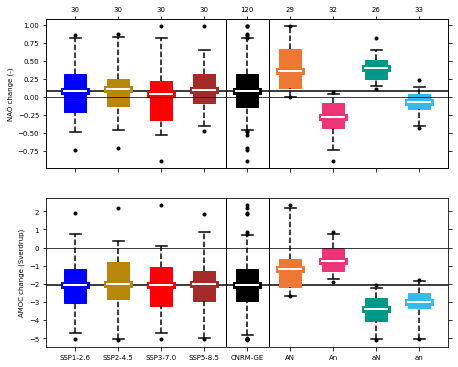

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (double_column_width, 150*mm), sharex=True)

for iD, _driver in enumerate(['NAO', 'AMOC']):
    print(_driver)

    _data = driver_ano[_driver]

    _members = list(_data.member.values); _members.sort(); _data.sortby('member')
    _members_dict = cc.cmip6.get_members_dict(_members)

    model_data = {_model: [] for _model in _members_dict}
    experiment_data = {_experiment: [] for _experiment in experiments}
    experiment_data_weights = {_experiment: [] for _experiment in experiments}

    for iM, _model in enumerate(_members_dict):
        for i, _experiment in enumerate(experiments):
            if _experiment in _members_dict[_model].keys():
                for _member in _members_dict[_model][_experiment]:
                    experiment_data[_experiment].append(float(_data.sel(member=_member).values))
                    experiment_data_weights[_experiment].append(da_weight.sel(member=_member).values)
    
    tick_positions = list(); tick_labels = list()
    for iE, _experiment in enumerate(experiments):
        ccplt.boxplot(
            [experiment_data[_experiment]],
            weights = [experiment_data_weights[_experiment]],
            color = [experiment_colors[_experiment]], bar = bp_median_mean, box = bp_box, ext = bp_ext,
            dx=iE, width = 0.5,
            ax = ax[iD])
        tick_positions.append(iE)
        tick_labels.append(len(experiment_data[_experiment]))
    ax[iD].yaxis.set_ticks_position('both')
    ax[iD].axhline(y=0,color='k',lw=.5)
    ax[iD].set_xticks(np.arange(len(experiments))+.5-0.5)
    ax[iD].set_xticklabels([experiment_labels[_experiment] for _experiment in experiments], rotation=0)

    tick_positions.append(len(experiments))
    tick_labels.append(len(_data.member))

    for iS, _sto in enumerate(story.labels):
        _story_members = list(set(story.families[story.stories[iS]]['label']).intersection(set(_members)))
        ccplt.boxplot(
            [_data.sel(member=_story_members)],
            weights = [da_weight.sel(member=_story_members)],
            color = [story.colors[iS]],
            bar = bp_median_mean, box = bp_box, ext = bp_ext,
            dx=len(experiments)+1+iS, width = 0.5,
            ax = ax[iD])
        tick_positions.append(len(experiments)+1+iS)
        tick_labels.append(len(_story_members))
    ccplt.boxplot(
        [_data], weights = [da_weight.sel(member=_members)],
        bar = bp_median_mean, box = bp_box, ext = bp_ext, dx=len(experiments), width = 0.5,
        ax = ax[iD])
    ax[iD].axhline(y=ccnp.mean(_data, weights=da_weight.sel(member=_members)),color='k', zorder=0)

    ax[iD].yaxis.set_ticks_position('both')
    ax[iD].axhline(y=0,color='k',lw=.5)
    ax[iD].set_xticks(np.arange(len(experiments)+1+len(story.stories))+.5-0.5)
    ax[iD].set_xticklabels([cc.cmip6.experiment_dict[_experiment]['name'] for _experiment in experiments]+ensemble_name+story.stories)
    _unit = _data.attrs['units'] if _data.attrs['units'] != '' else '-'
    ax[iD].set_ylabel(_driver+' '+anomaly_name+' ('+_unit+')')
    for i in range(2):
        ax[iD].axvline(x=len(experiments)+i-0.5,color='k',lw=1)
ax2 = ax[0].twiny()
ax2.set_xlim(ax[0].get_xlim())
ax2.set_xticks(tick_positions)
ax2.set_xticklabels(tick_labels)
plt.savefig(figDir+saveName+'-AMOC_NAO_boxplot_SSP_story.pdf', transparent=True)

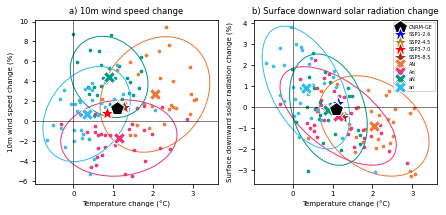

In [ ]:
import math
_region = 'NEU'
_variable = 'tas'

fig, ax = plt.subplots(1, 2, figsize = (double_column_width, 75*mm),
                       sharex=True, sharey=False)
for i, _target in enumerate(['sfcWind_NEU_land', 'rsds_NEU_land']):
    ax[i]=ax[i]
    if _variable+'_' not in _target and _region in _target:
        _Y = main_target_ano.get(_target)
        _X = main_target_ano.get(_variable+'_'+_region+'_land').sel(member = _Y.member)
        _da_weight = da_weight.sel(member=_Y.member)
        ax[i].plot(ccnp.mean(_X, weights=_da_weight), ccnp.mean(_Y, weights=_da_weight), ls='',
                   ms = 15, marker = 'p', c = 'k', label=ensemble_name[0], mec='w', zorder=7)
        if len(experiments) != 1:
            for _experiment in experiments:
                _members_expriment = [_member for _member in _Y.member.values if _experiment in _member]
                ax[i].plot(ccnp.mean(_X.sel(member = _members_expriment), weights=_da_weight.sel(member=_members_expriment)),
                           ccnp.mean(_Y.sel(member = _members_expriment), weights=_da_weight.sel(member=_members_expriment)),
                           ms = 15, marker = '*', c = cc.cmip6.experiment_dict[_experiment]['color'], ls='',
                           label=experiment_labels[_experiment], mec='w', zorder=5)
        for iS, _sto in enumerate(story.families):
            for _model in members_dict.keys():
                _story_members_model = list(set([_member for _member in story.families[_sto]['label'] if _model in _member]).intersection(set(list(_Y.member.values))))
                ax[i].scatter(_X.sel(member=_story_members_model),
                            _Y.sel(member=_story_members_model),
                            s = 7, c = story.colors[iS], marker = model_markers[_model])
                ax[i].plot(_X.sel(member=_story_members_model).mean(), _Y.sel(member=_story_members_model).mean(),
                           ms = 12, marker = 'X', c = story.colors[iS], label=story.stories[iS], ls='', mec='w', zorder=5)
                ccplt.confidence_ellipse(_X.sel(member=_story_members_model), _Y.sel(member=_story_members_model),
                                        ax=ax[i], n_std=2., edgecolor=story.colors[iS])
        ax[i].set_title(subfigure_label[i]+cc.cmip6.name_dict[_target.split('_')[0]].capitalize()+' change')
        xMin, xMax = ax[i].get_xlim(); ax[i].set_xlim(xMin, xMax); yMin, yMax = ax[i].get_ylim(); xMin2, xMax2 = ax[i].get_xlim(); ax[i].set_xlim(xMin2, xMax2)
        if xMin < 0. and xMax > 0.:
            ax[i].axvline(x=0, color='k', lw=.5)
        if yMin < 0. and yMax > 0.:
            ax[i].axhline(y=0, color='k', lw=.5)
        ax[i].set_xlabel(cc.cmip6.name_dict[_variable].capitalize()+' '+anomaly_name+' (°C)')
        ax[i].set_ylabel(cc.cmip6.name_dict[_target.split('_')[0]].capitalize()+' '+anomaly_name+' ('+_Y.attrs['units']+')')

ax[-1].legend(loc='upper right', fontsize=5)

plt.savefig(figDir+saveName+'-tas_physical_consistency_SI'+figExt,transparent=True)

In [ ]:
print("My work is done.")

My work is done.
